# Program - plot-var_2d_time_lev-cn_xy_flexible-TaiESM_hindcast

**Purpose**

read TaiESM hindcast data and make plots for time-level dimension, including contour, time series, and profiles.

**Content**
- read data: Read TaiESM hindcast data at a grid point (lat, lon) and selected time range 
- set characteristics for plots, such as time tick mark labels, color map, etc.
- plot time series (xy_series)
- plot profiles for N variables at one time step (xy_profile_Nv1t)
- plot profiles for 1 variable at multiple time step (xy_profile_1vNt)
- plot time-level cross section (cn_time_level)

**Author:** Yi-Hsuan Chen (yihsuan@umich.edu)

**Date:** 
March 2025

**Reference program:**
Thanks for chatGPT.


In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np
import xarray as xr
import io, os, sys, types

import yhc_module as yhc
#import read_data as read_data   ## on GFDL PP/AN
#import read_data_big as read_data    ## on my Mac

#--- silence dask large chunk and silence the warning.
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

# Functions

## ----- read data -----

## select_region_ds

In [3]:
##################
##################
##################
def select_region_ds(ds,
                  region="lat_lon",
                  lat=None, lon=None, 
                 ):

    func_name = "select_ds_region"
    
    #--- given the lat/lon range of a region
    if (region == "NE_CA"):
        #lowerlon=235; upperlon=245; lowerlat=28; upperlat=35
        lowerlon=225; upperlon=250; lowerlat=24; upperlat=40

    elif (region == "DYCOMS"): 
        #--- reference: Eyeballing in Fig. 1 in Stevens et al. (2007, MWR)
        region_name = "DYCOMS (29.5-33N, 120-123.5W)"
        lowerlat =  29.5   # 29.5N
        upperlat =  33     # 33N
        lowerlon =  236.5  # 123.5W
        upperlon =  240    # 120W

    elif (region == "lat_lon"): 
        if lat is None or lon is None:
            error_msg = f"ERROR: function [{func_name}] needs lat [{lat}] and lon [{lon}] when region='lat_lon'"
            raise KeyError(error_msg)
    
    else:
        lowerlon=-1000; upperlon=1000; lowerlat=-1000; upperlat=1000

    #--- select for in the given region
    if (region == "lat_lon"):
        lat_index, lon_index = get_lat_lon_indexes(ds, lat, lon)
        ds_region = ds.isel(lat=lat_index, lon=lon_index)

    else:
        lon_slice = slice(lowerlon, upperlon)
        lat_slice = slice(lowerlat, upperlat)
        ds_region = ds.sel(lat=lat_slice, lon=lon_slice)
    
    return ds_region

##################
##################
##################
def get_lat_lon_indexes(ds, lat, lon):
    lat_index = abs(ds['lat'] - lat).argmin().item()
    lon_index = abs(ds['lon'] - lon).argmin().item()

    return lat_index, lon_index

#-----------
# do_test
#-----------

do_test="112"
#do_test=False

if (do_test == "111"):
    choice = "custom_Ttend_3hr"
    icdate = "20010710"
    ds1 = read_data.read_TaiESM1_hindcast_icdate_files(choice, icdate, file_dates=5)
    
    lat=31.5 ; lon=236.5
    
    ds1_region = select_region_ds(ds1, region="lat_lon", lat=lat, lon=lon)

#ds1_region

## lat_lon_weighted_avg

In [4]:
import xarray as xr
import numpy as np

def lat_lon_weighted_avg(ds: xr.Dataset, lat_name: str = 'lat', lon_name: str = 'lon') -> xr.Dataset:
    """
    Compute the latitude-weighted average of an xarray.Dataset over lat and lon dimensions,
    only for variables that have both lat and lon in their coordinates.
    
    Parameters:
    ds (xr.Dataset): Input dataset with latitude and longitude dimensions.
    lat_name (str): Name of the latitude coordinate in the dataset.
    lon_name (str): Name of the longitude coordinate in the dataset.
    
    Returns:
    xr.Dataset: Dataset with lat/lon dimensions averaged using latitude weighting.
    """
    # Select only numeric variables that have both lat and lon as dimensions
    valid_vars = {
        var: ds[var] for var in ds.data_vars
        if np.issubdtype(ds[var].dtype, np.number) and {lat_name, lon_name}.issubset(ds[var].dims)
    }
    
    if not valid_vars:
        raise ValueError("No valid variables found with both lat and lon dimensions.")
    
    ds = xr.Dataset(valid_vars, coords=ds.coords)
    
    # Convert latitudes to radians for weighting
    lat_rad = np.deg2rad(ds[lat_name])
    
    # Compute latitude weights (cosine of latitude)
    weights = np.cos(lat_rad)
    
    # Normalize weights only over lat dimension
    weights /= weights.sum(dim=lat_name)
    
    # Compute weighted mean using dot product for efficiency
    weighted_mean = ds.weighted(weights).mean(dim=[lat_name, lon_name])
    
    return weighted_mean


## read_hindcast_icdate_lat_lon

In [5]:
def assign_ds_attrs(ds: xr.Dataset,
                    region, lat_values, lon_values):
    ds = ds.assign_attrs(
        avg_region=region,
        avg_lat=lat_values,
        avg_lon=lon_values,
    )
    return ds

def read_hindcast_icdate_lat_lon(icdate, 
    icdata_option = "ERA5", 
    ss5="00000",
    region=None,
    lat=None, lon=None,
    ):

    file_dates = 5

    #--- read datasets
    choice = "custom_Ttend_3hr"
    ds_Ttend = read_data.read_TaiESM1_hindcast_icdate_files(choice, icdate, icdata_option=icdata_option, file_dates=file_dates, ss5=ss5)

    choice = "custom_state_3hr"
    ds_state = read_data.read_TaiESM1_hindcast_icdate_files(choice, icdate, icdata_option=icdata_option, file_dates=file_dates, ss5=ss5)

    choice = "custom_Qtend_3hr"
    ds_Qtend = read_data.read_TaiESM1_hindcast_icdate_files(choice, icdate, icdata_option=icdata_option, file_dates=file_dates, ss5=ss5)

    choice = "custom_2d_1hr"
    ds_2d = read_data.read_TaiESM1_hindcast_icdate_files(choice, icdate, icdata_option=icdata_option, file_dates=file_dates, ss5=ss5)

    #--- diagnose variables in all ds
    yhc.diagnose_var(ds_state, ["play","plev","Z3_ilev","QT", "THETA_diag","THETA_L"])
    yhc.diagnose_var(ds_Ttend, ["DT_SUM_PHYS", "DT_deep"])
    yhc.diagnose_var(ds_Qtend, ["DQV_SUM_PHYS", "DQL_SUM_PHYS", "DQV_deep", "DQV_SUM_PHYS_no_MA_VD", "DQL_SUM_PHYS_no_MA_VD" ])

    #--- get data at the given lat/lon
    ds_Ttend_latlon = select_region_ds(ds_Ttend, region=region, lat=lat, lon=lon)
    ds_Qtend_latlon = select_region_ds(ds_Qtend, region=region, lat=lat, lon=lon)
    ds_state_latlon = select_region_ds(ds_state, region=region, lat=lat, lon=lon)
    ds_1d_time_latlon = select_region_ds(ds_2d, region=region, lat=lat, lon=lon)

    lat_values = ds_state_latlon['lat'].values.tolist()
    lon_values = ds_state_latlon['lon'].values.tolist()

    if region != "lat_lon":        
        ds_state_latlon = lat_lon_weighted_avg(ds_state_latlon)
        ds_state_latlon = assign_ds_attrs(ds_state_latlon, region, lat_values, lon_values)
        ds_Ttend_latlon = lat_lon_weighted_avg(ds_Ttend_latlon)
        ds_Ttend_latlon = assign_ds_attrs(ds_Ttend_latlon, region, lat_values, lon_values)
        ds_Qtend_latlon = lat_lon_weighted_avg(ds_Qtend_latlon)
        ds_Qtend_latlon = assign_ds_attrs(ds_Qtend_latlon, region, lat_values, lon_values)
        ds_1d_time_latlon = lat_lon_weighted_avg(ds_1d_time_latlon)
        ds_1d_time_latlon = assign_ds_attrs(ds_1d_time_latlon, region, lat_values, lon_values)
    
    return ds_state_latlon, ds_Ttend_latlon, ds_Qtend_latlon, ds_1d_time_latlon

#-----------
# do_test
#-----------

do_test="112"
#do_test=False

if (do_test == "111"):
    icdate = "20010707" ; ss5="00000"
    #icdate = "20010711" ; ss5="43200"

    #region = "DYCOMS"

    region = "lat_lon" ; lat=30 ; lon=240
    #ds_state_latlon, ds_Ttend_latlon, ds_Qtend_latlon, ds_1d_time_latlon = read_hindcast_icdate_lat_lon(icdate, region=region)
    icdata_option = "qq02_macrop_tpdf"
    ds_state_latlon, ds_Ttend_latlon, ds_Qtend_latlon, ds_1d_time_latlon = read_hindcast_icdate_lat_lon(icdate, icdata_option=icdata_option, 
                                                                                                        region=region, lat=lat, lon=lon, ss5=ss5)

#ds_state_latlon
#ds_Ttend_latlon
#ds_Qtend_latlon
#ds_1d_time_latlon

#pp = yhc.get_area_avg(ds_state_latlon, region="DYCOMS")

## get_ds_time_level_2d_vars_for_xy_plot

In [6]:
import cftime

###############
###############
###############
class read_hindcast_data:
    def __init__(self, icdate, icdata_option="ERA5", ss5="00000", region=None, lat=None, lon=None):
        """
        Initialize the object with initial datasets based on the provided initial conditions (icdate), 
        latitude (lat), and longitude (lon).
        
        Args:
        - icdate: The initial condition date for the hindcast (string or datetime)
        - icdata_option: Option for selecting hindcast data (string, default="ERA5")
        - region: Region identifier for the dataset (string, optional)
        - lat: Latitude coordinate for the data (float, optional)
        - lon: Longitude coordinate for the data (float, optional)
        """
        self.icdata_option = icdata_option  # Store the icdata_option
        self.region = region  # Store the region
        self.datasets = {}  # Store datasets in a dictionary
        self.load_data(icdate, lat, lon)  # Load initial datasets

    def load_data(self, icdate, lat, lon):
        """
        Load datasets dynamically using the given initial condition date, latitude, and longitude. 
        The datasets are retrieved and stored in the `self.datasets` dictionary.
        
        Args:
        - icdate: The initial condition date for the hindcast (string or datetime)
        - lat: Latitude coordinate for the data (float)
        - lon: Longitude coordinate for the data (float)
        """
        try:
            # Retrieve data from the hindcast based on the given initial conditions
            ds_state_latlon, ds_Ttend_latlon, ds_Qtend_latlon, ds_1d_time_latlon = read_hindcast_icdate_lat_lon(
                icdate, ss5=ss5, icdata_option=self.icdata_option, region=self.region, lat=lat, lon=lon,
            )
            
            # Store the datasets in the dictionary
            self.datasets["ds_state"] = ds_state_latlon  # Main state dataset
            self.datasets["ds_Ttend"] = ds_Ttend_latlon  # Temperature tendency dataset
            self.datasets["ds_Qtend"] = ds_Qtend_latlon  # Q tendency dataset
            self.datasets["ds_1d_time"] = ds_1d_time_latlon  # Q tendency dataset
            self.datasets["play"] = ds_state_latlon["play"]  # Play variable from state dataset
            self.datasets["Z3"] = ds_state_latlon["Z3"]  # Store "Z3" from state dataset
            self.datasets["plev"] = ds_state_latlon["plev"]  # Store "Z3" from state dataset
            self.datasets["Z3_ilev"] = ds_state_latlon["Z3_ilev"]  # Store "Z3" from state dataset

            # add new attributes
            self.datasets["play"].attrs["coord_label"] = "Pressure (hPa)"
            self.datasets["play"].attrs["do_inverse_yaxis"] = True
            self.datasets["plev"].attrs["coord_label"] = "Pressure (hPa)"
            self.datasets["plev"].attrs["do_inverse_yaxis"] = True
            
            self.datasets["Z3"].attrs["coord_label"] = "Altitude (m)"
            self.datasets["Z3"].attrs["do_inverse_yaxis"] = False
            self.datasets["Z3_ilev"].attrs["coord_label"] = "Altitude (m)"
            self.datasets["Z3_ilev"].attrs["do_inverse_yaxis"] = False
        
        except Exception as e:
            print(f"Error loading data: {e}")  # Error handling if data loading fails
            self.datasets = {}  # Reset the datasets in case of an error

    def get(self, data):
        """
        Retrieve a specific dataset by name.

        Args:
        - data: The name of the dataset to retrieve (string)
        
        Returns:
        - The requested dataset or None if the dataset is not found.
        """
        return self.datasets.get(data, None)

    def set(self, key, value):
        """
        Modify or add a dataset to the dictionary dynamically.

        Args:
        - key: The name of the dataset (string)
        - value: The dataset value (object)
        """
        self.datasets[key] = value  # Add or update the dataset in the dictionary

###############
###############
###############
def select_ds_time_period(ds_dict, lev_dict, start_str=None, end_str=None):
    """
    Selects data from a dictionary of xarray Datasets within a specified time period.

    Parameters:
        ds_dict (dict): A dictionary of xarray Datasets, where each dataset contains a 'time' coordinate in cftime.DatetimeNoLeap format.
        start_str (str): Start time in "YYYYMMDD_HHMMSS" format.
        end_str (str): End time in "YYYYMMDD_HHMMSS" format.

    Returns:
        dict: A dictionary of xarray Datasets within the specified time range.
    """

    # Assuming all datasets in ds_dict have the same time range, get the global time range from one of them
    time_min, time_max = ds_dict[next(iter(ds_dict))].time.min().item(), ds_dict[next(iter(ds_dict))].time.max().item()

    # Check if the start_str and end_str are provided
    if start_str:
        # Parse start time from "YYYYMMDD_HHMMSS" format
        start_time = cftime.DatetimeNoLeap(
            int(start_str[:4]),  # Year
            int(start_str[4:6]),  # Month
            int(start_str[6:8]),  # Day
            int(start_str[9:11]),  # Hour
            int(start_str[11:13]),  # Minute
            int(start_str[13:15])   # Second
        )

        # Validate start_time within dataset range
        if start_time < time_min or start_time > time_max:
            raise ValueError(f"start_str ({start_str}) is out of range: {time_min} to {time_max}")
    else:
        start_time = time_min  # Default to minimum time in dataset if start_str is not provided

    if end_str:
        # Parse end time from "YYYYMMDD_HHMMSS" format
        end_time = cftime.DatetimeNoLeap(
            int(end_str[:4]),  # Year
            int(end_str[4:6]),  # Month
            int(end_str[6:8]),  # Day
            int(end_str[9:11]),  # Hour
            int(end_str[11:13]),  # Minute
            int(end_str[13:15])   # Second
        )

        # Validate end_time within dataset range
        if end_time < time_min or end_time > time_max:
            raise ValueError(f"end_str ({end_str}) is out of range: {time_min} to {time_max}")
    else:
        end_time = time_max  # Default to maximum time in dataset if end_str is not provided

   # Check if end_time is greater than start_time
    if end_time < start_time:
        raise ValueError(f"end_time ({end_time}) cannot be earlier than start_time ({start_time})")
        
    # Apply the time selection to each dataset in the dictionary and return the updated dictionary
    ds_dict_filtered = {key: ds.sel(time=slice(start_time, end_time)) for key, ds in ds_dict.items()}
    lev_dict_filtered = {key: lev.sel(time=slice(start_time, end_time)) for key, lev in lev_dict.items()}

    return ds_dict_filtered, lev_dict_filtered

###############
###############
###############
def select_lev_range_old(ds_dict, lev_dict, lev_select=None, lev_min=None, lev_max=None):
    """
    Filters datasets within a specified lev range based on a selected variable from lev_dict.

    Parameters:
        ds_dict (dict): Dictionary containing the datasets (e.g., 'ds_state', 'ds_Ttend').
        lev_dict (dict): Dictionary containing the variables like 'play', 'Z3'.
        lev_select (str): Select which variable from lev_dict to use ('play' or 'Z3').
        lev_min (float): Minimum lev value for filtering.
        lev_max (float): Maximum lev value for filtering.

    Returns:
        tuple: Filtered ds_dict and lev_dict.
    """

    if lev_min is not None and lev_max is not None:
        # Check which variable to use for filtering
        if lev_select == "pressure":
            mask_lev = (lev_dict["play"] > lev_min) & (lev_dict["play"] < lev_max)
            mask_ilev = (lev_dict["plev"] > lev_min) & (lev_dict["plev"] < lev_max)

        elif lev_select == "play":
            mask = (lev_dict["play"] > lev_min) & (lev_dict["play"] < lev_max)
        elif lev_select == "plev":
            mask = (lev_dict["plev"] > lev_min) & (lev_dict["plev"] < lev_max)
        elif lev_select == "Z3":
            mask = (lev_dict["Z3"] > lev_min) & (lev_dict["Z3"] < lev_max)
        elif lev_select == "Z3_ilev":
            mask = (lev_dict["Z3_ilev"] > lev_min) & (lev_dict["Z3_ilev"] < lev_max)
        else:
            raise ValueError(f"Invalid lev_select value: {lev_select}. Must be ('play', 'plev', 'Z3', 'Z3_ilev'")
        
        # Compute the mask if it's a dask array
        mask_lev_computed  = mask_lev.compute()  # Eager evaluation
        lev_indices = mask_lev_computed.any(dim='time')  # Boolean array (lev,) for condition across all time
        lev_values_to_select = lev_dict["play"].lev.values[lev_indices]  # Get lev values

        # Compute the mask if it's a dask array
        mask_ilev_computed  = mask_ilev.compute()  # Eager evaluation
        ilev_indices = mask_ilev_computed.any(dim='time')  # Boolean array (lev,) for condition across all time
        ilev_values_to_select = lev_dict["plev"].ilev.values[ilev_indices]  # Get lev values

        lev_dict_filtered = {
            key: (
                val.sel(lev=lev_values_to_select) if key == "play" or key == "Z3" 
                else val.sel(ilev=lev_values_to_select) if key == "plev" or key == "Z3_ilev" 
                else val
            )
            for key, val in lev_dict.items()
                            }
            #print(ds_dict.items

        ds_dict_filtered = ds_dict.copy()
        
        if lev_select == "play" or lev_select == "Z3":
            lev_indices = mask_computed.any(dim='time')  # Boolean array (lev,) for condition across all time
            lev_values_to_select = lev_dict["play"].lev.values[lev_indices]  # Get lev values from play or Z3

            ds_dict_filtered = {key: val.sel(lev=lev_values_to_select) for key, val in ds_dict.items()}
            lev_dict_filtered = {
                key: (
                    val.sel(lev=lev_values_to_select) if key == "play" or key == "Z3" 
                    else val.sel(ilev=ilev_values_to_select) if key == "plev" or key == "Z3_ilev" 
                    else val
                )
                for key, val in lev_dict.items()
                                }
            #lev_dict_filtered = {key: val.sel(lev=lev_values_to_select) for key, val in lev_dict.items()}   
            #lev_dict_filtered = {key: (val.sel(lev=lev_values_to_select) if key == "play" or key == "Z3" else val) for key, val in lev_dict.items()}
            
            #ds_dict_filtered = ds_dict.copy()
            #lev_dict_filtered = lev_dict.copy()
        
        # Get lev indices where the condition is True across all time points
        #if lev_select == "play" or lev_select == "Z3":
         #   lev_indices = mask_computed.any(dim='time')  # Boolean array (lev,) for condition across all time
        #lev_indices 
        
        # Extract the lev values that match the condition
        #lev_values_to_select = lev_dict["play"].lev.values[lev_indices]  # Get lev values from play or Z3
        #ilev_values_to_select = lev_dict["plev"].ilev.values[ilev_indices]  # Get lev values from play or Z3
    
        # Apply filtering to the datasets using the lev values
        #if lev_select == "play" or lev_select == "Z3":
        #    ds_dict_filtered = {key: val.sel(lev=lev_values_to_select) for key, val in ds_dict.items()}
        #    lev_dict_filtered = {key: val.sel(lev=lev_values_to_select) for key, val in lev_dict.items()}
        #elif lev_select == "plev" or lev_select == "Z3_ilev":
        #    ds_dict_filtered = {key: val.sel(ilev=ilev_values_to_select) for key, val in ds_dict.items()}
        #    lev_dict_filtered = {key: val.sel(ilev=ilev_values_to_select) for key, val in lev_dict.items()}
        
        return ds_dict_filtered, lev_dict_filtered
    else:
        return ds_dict, lev_dict

###############
###############
###############
def select_lev_range(ds_dict, lev_dict, lev_select=None, lev_coord='lev', lev_min=None, lev_max=None):
    """
    Filters datasets within a specified lev range based on a selected variable from lev_dict.

    Parameters:
        ds_dict (dict): Dictionary containing the datasets (e.g., 'ds_state', 'ds_Ttend').
        lev_dict (dict): Dictionary containing the variables like 'play', 'Z3'.
        lev_select (str): Select which variable from lev_dict to use ('play' or 'Z3').
        lev_coord (str): The coordinate to filter on, either 'lev' or 'ilev'.
        lev_min (float): Minimum lev value for filtering.
        lev_max (float): Maximum lev value for filtering.

    Returns:
        tuple: Filtered ds_dict and lev_dict.
    """

    if lev_min is not None and lev_max is not None:
        # Check if lev_select exists in lev_dict
        if lev_select not in lev_dict:
            raise ValueError(f"Selected variable {lev_select} is not present in lev_dict.")
        
        # Check if the selected coordinate exists in lev_dict[lev_select]
        if lev_coord not in lev_dict[lev_select].coords:
            raise ValueError(f"Coordinate '{lev_coord}' is not present in the selected variable '{lev_select}'.")

        # Get lev values
        lev_values = lev_dict[lev_select].values

        # Apply the mask to get a boolean array (time, lev or ilev)
        mask = (lev_values > lev_min) & (lev_values < lev_max)

        # Reduce across the time dimension to find the valid levels
        lev_indices_to_select = np.any(mask, axis=0)  # Boolean array for each lev dimension
        selected_lev_indices = np.where(lev_indices_to_select)[0]  # Indices of levs that pass the condition

        # Filter datasets, only if they have the specified lev_coord dimension
        ds_dict_filtered = {
            key: (val.isel({lev_coord: selected_lev_indices}) if lev_coord in val.dims else val) 
            for key, val in ds_dict.items()
        }

        # Filter lev_dict similarly
        lev_dict_filtered = {
            key: (val.isel({lev_coord: selected_lev_indices}) if lev_coord in val.dims else val) 
            for key, val in lev_dict.items()
        }

        return ds_dict_filtered, lev_dict_filtered

    else:
        return ds_dict, lev_dict

###############
###############
###############
def get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option="ERA5",
                                          ss5="00000", 
                                          region=None, lat=None, lon=None,
                                         lev_select=None, lev_min=None, lev_max=None,
                                         start_str=None, end_str=None,
                                         ):
    """
    Retrieve datasets containing variables with 2D dimensions [time, level] for use in XY plots.
    The function returns datasets for key variables such as state, Ttend, Qtend, and other related variables 
    like play and Z3.

    Args:
    - icdate: The initial condition date for the hindcast (string or datetime)
    - lat: Latitude coordinate for the data (float)
    - lon: Longitude coordinate for the data (float)

    Returns:
    - ds_dict: Dictionary containing the primary datasets (state, Ttend, Qtend)
    - lev_dict: Dictionary containing additional variables for XY plot (play, Z3)
    """

    func_name = "get_ds_time_level_2d_vars_for_xy_plot"
    
    # Create an instance of the read_hindcast_data class
    hindcast_data = read_hindcast_data(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon)

    # Retrieve the datasets for main variables
    ds_dict = {
        "state": hindcast_data.get("ds_state"),  # Main state dataset
        "Ttend": hindcast_data.get("ds_Ttend"),  # Temperature tendency dataset
        "Qtend": hindcast_data.get("ds_Qtend"),  # Q tendency dataset
        "1d_time": hindcast_data.get("ds_1d_time"),  # time series dataset
    }

    # Additional variables for XY plot
    lev_dict = {
        "play": hindcast_data.get("play"),  # Play variable for plotting
        "plev": hindcast_data.get("plev"),  # Play variable for plotting
        "Z3": hindcast_data.get("Z3"),  # Z3 variable for plotting
        "Z3_ilev": hindcast_data.get("Z3_ilev"),  # Z3 variable for plotting

    }

    # select level range
    if (lev_select == "play"):
        ds_dict, lev_dict = select_lev_range(ds_dict, lev_dict, lev_select = "play", lev_coord="lev", lev_min=lev_min, lev_max=lev_max)
        ds_dict, lev_dict = select_lev_range(ds_dict, lev_dict, lev_select = "plev", lev_coord="ilev", lev_min=lev_min, lev_max=lev_max)
    elif (lev_select == "Z3"):
        ds_dict, lev_dict = select_lev_range(ds_dict, lev_dict, lev_select = "Z3", lev_coord="lev", lev_min=lev_min, lev_max=lev_max)
        ds_dict, lev_dict = select_lev_range(ds_dict, lev_dict, lev_select = "Z3_ilev", lev_coord="ilev", lev_min=lev_min, lev_max=lev_max)        
    elif (lev_select is None):
        pass
    else:
        raise ValueError(f"[{func_name}]: Invalid lev_select value: {lev_select}. Must be 'play' or 'Z3'.")
    
    # select time range
    ds_dict, lev_dict = select_ds_time_period(ds_dict, lev_dict, start_str=start_str, end_str=end_str)

    return ds_dict, lev_dict

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):
    # Example initial condition date, latitude, and longitude
    #icdate = "20010711" ; ss5="43200"
    icdate = "20010707" ; ss5="00000"

    #region="lat_lon" ; lat = 31.5 ; lon = 236.5
    region = "DYCOMS"
    icdata_option = "qq02_macrop_park"
    
    # select all time and lev
    #ds_dict, lev_dict = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, region=region, lat=lat, lon=lon)

    # select lev range
    lev_select = "Z3" ; lev_max = 3000 ; lev_min = 1000
    #lev_select = "play" ; lev_max = 1000 ; lev_min = 500
    ds_dict, lev_dict = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lev_select=lev_select, lev_min=lev_min, lev_max=lev_max)

    # select time range
    #start_str = "20010711_000000"
    #end_str = "20010713_000000"
    #ds_dict, lev_dict = get_ds_time_level_2d_vars_for_xy_plot(icdate, lat, lon, 
    #                                                         start_str=start_str, end_str=end_str)

    # select both time and lev range
    #ds_dict, lev_dict = get_ds_time_level_2d_vars_for_xy_plot(icdate, lat, lon, 
    #                                                         lev_select=lev_select, lev_min=lev_min, lev_max=lev_max, 
    #                                                         start_str=start_str, end_str=end_str)

#ds_dict['Qtend']
#ds_dict['1d_time']
#print(ds_dict['state'])
#lev_dict
#lev_dict['play']
#lev_dict.items()



## get_scm_ds_time_level_2d_vars

In [7]:
###############
###############
###############

def load_scm_datasets(files_scm, do_diag_var="yhc"):
    """
    Load multiple SCM NetCDF datasets into a dictionary using xarray.

    Parameters:
        files_scm (dict): A dictionary mapping keys to file paths.

    Returns:
        dict: A dictionary mapping the same keys to xarray.Dataset objects.

    Raises:
        FileNotFoundError: If any file in the dictionary does not exist.
    """

    vars_diag_yhc = [
        "play","plev","Z3_ilev", 
        "DT_SUM_PHYS", "DT_deep",
        "DQV_SUM_PHYS", "DQL_SUM_PHYS", "DQV_deep", "DQV_SUM_PHYS_no_MA_VD", "DQL_SUM_PHYS_no_MA_VD",
        "QT", "THETA_diag","THETA_L",
    ]
    
    # Check that all files exist
    for key, filepath in files_scm.items():
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"File not found for key '{key}': {filepath}")
    
    # Load datasets
    ds_scm = {}
    for key, filepath in files_scm.items():
        ds = xr.open_dataset(filepath)
        if do_diag_var == "yhc" and yhc is not None:
            yhc.diagnose_var(ds, vars_diag_yhc)
        ds_sel = ds.sel(lat=0, lon=0, method="nearest")  # Select lat=0, lon=0
        ds_scm[key] = ds_sel
    
    return ds_scm

###############
###############
###############
def select_ds_time_period_one(ds, start_str=None, end_str=None):
    """
    Selects data from a dictionary of xarray Datasets within a specified time period.

    Parameters:
        ds (dataset): An xarray Datasets, where each dataset contains a 'time' coordinate in cftime.DatetimeNoLeap format.
        start_str (str): Start time in "YYYYMMDD_HHMMSS" format.
        end_str (str): End time in "YYYYMMDD_HHMMSS" format.

    Returns:
        dict: A dictionary of xarray Datasets within the specified time range.
    """

    # Assuming all datasets in ds_dict have the same time range, get the global time range from one of them
    time_min, time_max = ds.time.min().item(), ds.time.max().item()

    # Check if the start_str and end_str are provided
    if start_str:
        # Parse start time from "YYYYMMDD_HHMMSS" format
        start_time = cftime.DatetimeNoLeap(
            int(start_str[:4]),  # Year
            int(start_str[4:6]),  # Month
            int(start_str[6:8]),  # Day
            int(start_str[9:11]),  # Hour
            int(start_str[11:13]),  # Minute
            int(start_str[13:15])   # Second
        )

        # Validate start_time within dataset range
        if start_time < time_min or start_time > time_max:
            raise ValueError(f"start_str ({start_str}) is out of range: {time_min} to {time_max}")
    else:
        start_time = time_min  # Default to minimum time in dataset if start_str is not provided

    if end_str:
        # Parse end time from "YYYYMMDD_HHMMSS" format
        end_time = cftime.DatetimeNoLeap(
            int(end_str[:4]),  # Year
            int(end_str[4:6]),  # Month
            int(end_str[6:8]),  # Day
            int(end_str[9:11]),  # Hour
            int(end_str[11:13]),  # Minute
            int(end_str[13:15])   # Second
        )

        # Validate end_time within dataset range
        if end_time < time_min or end_time > time_max:
            raise ValueError(f"end_str ({end_str}) is out of range: {time_min} to {time_max}")
    else:
        end_time = time_max  # Default to maximum time in dataset if end_str is not provided

   # Check if end_time is greater than start_time
    if end_time < start_time:
        raise ValueError(f"end_time ({end_time}) cannot be earlier than start_time ({start_time})")
        
    # Apply the time selection to each dataset in the dictionary and return the updated dictionary
    ds_filtered = ds.sel(time=slice(start_time, end_time))

    return ds_filtered

###############
###############
###############
def select_vertical_range_by_var(ds, varname='Z3', lev_min=0, lev_max=2000):
    """
    Select vertical levels (along 'lev' or 'ilev') where a variable is within a given range,
    and apply this selection to all dataset variables that share the same vertical coordinate.

    Parameters:
        ds (xr.Dataset): The input xarray dataset.
        varname (str): Name of the variable to use for level selection (e.g., 'Z3', 'play').
        lev_min (float): Minimum value for selection (inclusive).
        lev_max (float): Maximum value for selection (inclusive).

    Returns:
        xr.Dataset: Filtered dataset.
    """
    if varname not in ds:
        raise ValueError(f"Variable '{varname}' not found in dataset.")

    var = ds[varname]
    vertical_coords = ['lev', 'ilev']
    vert_coord = next((dim for dim in vertical_coords if dim in var.dims), None)

    if vert_coord is None:
        raise ValueError(f"Variable '{varname}' must contain 'lev' or 'ilev' as a dimension.")

    # Create mask over the vertical coordinate
    mask = (var > lev_min) & (var < lev_max)
    mask_1d = mask.any(dim=[dim for dim in var.dims if dim != vert_coord])
    selected_indices = np.where(mask_1d.values)[0]

    #print(var)
    #print(selected_indices)
    
    # Apply selection to all variables that use the same vertical coordinate
    ds_filtered = ds.isel({vert_coord: selected_indices})

    return ds_filtered

###############
###############
###############
def get_scm_ds_time_level_2d_vars ( files_scm, 
                                    lev_select=None, lev_min=None, lev_max=None,
                                    start_str=None, end_str=None
                                  ):
    
    ds_scm_dict = load_scm_datasets(files_scm)

    ds_filtered = {}
    for key in ds_scm_dict:
        ds = ds_scm_dict[key]

        # select level range
        if (lev_select == "play"):
            ds = select_vertical_range_by_var(ds, varname = lev_select, lev_min=lev_min, lev_max=lev_max)
            ds = select_vertical_range_by_var(ds, varname = "plev", lev_min=lev_min, lev_max=lev_max)

        elif (lev_select == "Z3"):
            ds = select_vertical_range_by_var(ds, varname = lev_select, lev_min=lev_min, lev_max=lev_max)
            ds = select_vertical_range_by_var(ds, varname = "Z3_ilev", lev_min=lev_min, lev_max=lev_max)
        elif (lev_select is None):
            pass
        else:
            raise ValueError(f"[{func_name}]: Invalid lev_select value: {lev_select}. Must be 'play' or 'Z3'.")        

        # select time range
        ds = select_ds_time_period_one (ds, start_str=start_str, end_str=end_str)

        # return
        ds_filtered[key] = ds

    return ds_filtered

#------------
# do test
#------------

do_test = "112"
if (do_test == "111"):
    datapath = "/lfs/home/yihsuanc/test/x4-scm_dycoms/"
    
    files_scm = {
        "rf01_tpdf": datapath+"q2_scm_taiesm1.dycomsrf01.psflx.macrop_tpdf/run/q2_scm_taiesm1.dycomsrf01.psflx.macrop_tpdf.cam.h0.1999-07-11-00000.nc", 
        "rf01_updf": datapath+"q2_scm_taiesm1.dycomsrf01.psflx.macrop_updf/run/q2_scm_taiesm1.dycomsrf01.psflx.macrop_updf.cam.h0.1999-07-11-00000.nc",
        "rf02_tpdf": datapath+"q2_scm_taiesm1.dycomsrf02.psflx.macrop_tpdf/run/q2_scm_taiesm1.dycomsrf02.psflx.macrop_tpdf.cam.h0.1999-07-11-00000.nc",
        "rf02_updf": datapath+"q2_scm_taiesm1.dycomsrf02.psflx.macrop_updf/run/q2_scm_taiesm1.dycomsrf02.psflx.macrop_updf.cam.h0.1999-07-11-00000.nc",
    }

    #ds1 = get_scm_ds_time_level_2d_vars(files_scm)

    lev_select = "Z3" ; lev_max = 2000 ; lev_min = 0
    #lev_select = "play" ; lev_max = 1100 ; lev_min = 300
    start_str = "19990711_000000"
    end_str = "19990711_120000"    

    ds1 = get_scm_ds_time_level_2d_vars(files_scm, 
                                        lev_select=lev_select, lev_min=lev_min, lev_max=lev_max,
                                        start_str=start_str, end_str=end_str
                                       )
    

## ----- shared for cn and xy plots -----

## create_time_coord_labels

In [8]:
import numpy as np
import pandas as pd
import cftime
import warnings

def create_time_coord_labels(ds, time_interval, time_vert_lines=None):

    func_name = "create_time_coord_labels"
    
    # Convert cftime.DatetimeNoLeap to numpy datetime64 for better compatibility
    ds_times = np.array([np.datetime64(pd.Timestamp(t.year, t.month, t.day, t.hour, t.minute, t.second)) for t in ds["time"].values])

    # Convert time to numeric values (0 to len(time))
    time_numeric = np.arange(len(ds_times))

    # Set the x-axis ticks and labels for time
    time_ticks = np.arange(0, len(time_numeric), time_interval)
    time_labels = [pd.Timestamp(t).strftime('%m%d_%H') for t in ds_times[time_ticks]]

    # Process time_vert_lines if provided
    time_numeric_vert_lines = []
    if time_vert_lines:
        time_vert_lines_dt = np.array(pd.to_datetime(time_vert_lines, format='%Y%m%d_%H%M%S').to_numpy(), dtype='datetime64[ns]')

        for t in time_vert_lines_dt:
            # Check if t is within the dataset's time range
            if t < ds_times[0] or t > ds_times[-1]:
                warnings.warn(f"Warning [func {func_name}]: Time {t} is outside the dataset time range ({ds_times[0]} to {ds_times[-1]}). Skip to plot lines at t.", UserWarning)
                continue  # Skip this time
            
            idx = np.argmin(np.abs(ds_times - t))  # Find the closest index
            time_numeric_vert_lines.append(idx)

    return time_numeric, time_ticks, time_labels, time_numeric_vert_lines


time_interval = 3
time_vert_lines = ["20050711_120000", "20050711_060000"]
#time_numeric, time_ticks, time_label, time_numeric_vert_lines = create_time_coord_labels(ds_dict['state'], 
#                                                                                         time_interval=time_interval,
#                                                                                         time_vert_lines=time_vert_lines)
#print(time_numeric)
#print(time_ticks)
#print(time_label)
#print(time_numeric_vert_lines)

## generate_plot_xy_kwargs

In [9]:
################
################
################
def separate_var_dict(var_dict, default_style):
    """
    Separates the variable dictionary into two dictionaries:
    - One containing plot styling attributes ('color', 'marker', 'linestyle').
    - One containing other attributes (e.g., 'label').

    If 'color', 'marker', or 'linestyle' are missing, default values are assigned.

    Parameters:
    var_dict (dict): Dictionary mapping variable names to their plotting attributes.

    Returns:
    tuple: (dict with styling attributes, dict with other attributes)
    """
    style_keys = {'color', 'marker', 'linestyle'}  # Keys related to plot styles
    
    # Default style settings
    #default_style = {
    #    'color': 'blue',     # Default color
    #    'marker': 'x',        # Default marker
    #    'linestyle': '-'      # Default linestyle
    #}
    
    style_dict = {}  # Dictionary for color, marker, linestyle
    meta_dict = {}   # Dictionary for other attributes

    for var, attrs in var_dict.items():
        # Extract style-related attributes and apply defaults where necessary
        style_dict[var] = {k: attrs.get(k, default_style[k]) for k in style_keys}
        
        # Extract metadata attributes (anything not in style_keys)
        meta_dict[var] = {k: v for k, v in attrs.items() if k not in style_keys}

    return style_dict, meta_dict

################
################
################
def generate_plot_xy_kwargs(var_name, da, var_list, option_default=None):
    """
    Generate plot styling and metadata dictionaries for a given variable.
    
    Parameters:
    var_name (str): The primary variable name.
    da (xarray.DataArray): DataArray object to extract metadata.
    var_list (list): List of variable names.
    
    Returns:
    tuple: (style_dict, meta_dict) for the given var_name.
    """

    # Define colors for different processes
    #  
    #    * Line colors, https://matplotlib.org/stable/gallery/color/named_colors.html
    #        red (r), blue (b), green (g), cyan (c), magenta (m), yellow (y), black (k), white (w)
    #
    #.   * Line dash pattern, https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
    #.       {'-', '--', '-.', ':'} {solid, dashed, dashdot, dotted}
    #
    #.   * Markers, https://matplotlib.org/stable/api/markers_api.html
    #        {'.', 'o', '^', 's'} = {point, circle, triangle_up, square}  

    color_tot = 'black' ; color_dyn = 'darkgray' ; color_PT = 'red' ; color_sum = color_PT
    color_ZM = 'blue'   ; color_CMF = 'cyan'     ; color_DPDLF = 'royalblue' ; color_SHDLF = 'skyblue'
    color_MACP = 'green' ; color_MP = 'limegreen' ; color_QRL = 'orange' ; color_QRS = 'pink' 
    color_vdiff = 'purple' ; color_gwd = 'yellow'
    
    color_cyan = 'c' ; color_red = 'r' 
    
    # Define style and metadata information
    var_dict = {
        #--- T tendency 
        'TTEND_TOT': {'color': color_tot, 'label': 'Total=dyn+phys [TTEND_TOT]'},
        'DTCORE': {'color': color_dyn, 'label': 'Dynamics [DTCORE]'},
        'PTTEND': {'color': color_PT, 'label': 'All phys [PTTEND]'},
        'DT_deep': {'color': color_ZM, 'label': 'Deep convection [ZMDT+ZMMTT+EVAPTZM]'},
        'CMFDT': {'color': color_CMF, 'label': 'Shallow convection [CMFDT]'},
        'DPDLFT': {'color': color_DPDLF, 'label': 'Deep conv detrain [DPDLFT]'},
        'SHDLFT': {'color': color_SHDLF, 'label': 'Shallow conv detrain [SHDLFT]'},
        'MACPDT': {'color': color_MACP, 'label': 'Macrophysics [MACPDT]'},
        'MPDT': {'color': color_MP, 'label': 'Microphysics [MPCT]'},
        'QRL': {'color': color_QRL, 'label': 'LW radiation [QRL]'},
        'QRS': {'color': color_QRS, 'label': 'SW radiation [QRS]'},
        'DTV': {'color': color_vdiff, 'label': 'PBL & turbulence [DTV]'},
        'TTGWORO': {'color': color_gwd, 'label': 'grav wave drag [TTGWORO]'},
        'DT_SUM_PHYS': {'color': color_sum, 'label': 'Sum of all phys tend', 'linestyle': '--'},

        #--- QV tendency 
        'QVTEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [QVTEND_TOT]'},
        'DQVCORE': {'color':color_dyn, 'label': 'Dynamics [DQVCORE]'},
        'PTEQ': {'color':color_PT, 'label': 'All phys [PTEQ]'},
        'DQV_deep': {'color': color_ZM, 'label':'Deep convection [ZMDQ+EVAPQZM]'},
        'ZMDQ': {'color': color_ZM, 'label':'Deep convection [ZMDQ]'},
        'EVAPQZM': {'color': color_ZM, 'label':'Evap from deep conv [EVAPQZM]', 'linestyle': '--'},
        'CMFDQ': {'color': color_CMF, 'label': 'Shallow convection [CMFDLIQ]'},
        'MACPDQ': {'color':color_MACP, 'label':'Macrophysics [MACPDQ]'},
        'MPDQ': {'color':color_MP, 'label':'Microphysics [MPDQ]'},
        'VD01': {'color':color_vdiff, 'label': 'PBL & turbulence [VD01]'},
        'DQV_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},

        #--- QL tendency 
        'QLTEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [QLTEND_TOT]'},
        'DQLCORE': {'color':color_dyn, 'label': 'Dynamics [DQLCORE]'},
        'PTECLDLIQ': {'color':color_PT, 'label': 'All phys [PTECLDLIQ]'},
        'ZMDLIQ': {'color': color_ZM, 'label':'Deep convection [ZMDLIQ]'},
        'CMFDLIQ': {'color': color_CMF, 'label': 'Shallow convection [CMFDLIQ]'},
        'DPDLFLIQ': {'color':color_DPDLF, 'label': 'Deep conv detrain [DPDLFLIQ]'},
        'SHDLFLIQ': {'color':color_SHDLF, 'label':'Shallow conv detrain [SHDLFLIQ]'},
        'MACPDLIQ': {'color':color_MACP, 'label':'Macrophysics [MACPDLIQ]'},
        'MPDLIQ': {'color':color_MP, 'label':'Microphysics [MPDLIQ]'},
        'VDCLDLIQ': {'color':color_vdiff, 'label': 'PBL & turbulence [VDCLDLIQ]'},
        'DQL_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},

        #--- QI tendency
        'QITEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [QITEND_TOT]'},
        'DQICORE': {'color':color_dyn, 'label': 'Dynamics [DQICORE]'},
        'PTECLDICE': {'color':color_PT, 'label': 'All phys [PTECLDICE]'},
        'ZMDICE': {'color': color_ZM, 'label':'Deep convection [ZMDICE]'},
        'CMFDICE': {'color': color_CMF, 'label': 'Shallow convection [CMFDICE]'},
        'DPDLFICE': {'color':color_DPDLF, 'label': 'Deep conv detrain [DPDLFICE]'},
        'SHDLFICE': {'color':color_SHDLF, 'label':'Shallow conv detrain [SHDLFICE]'},
        'MACPDICE': {'color':color_MACP, 'label':'Macrophysics [MACPDICE]'},
        'MPDICE': {'color':color_MP, 'label':'Microphysics [MPDICE]'},
        'VDCLDICE': {'color':color_vdiff, 'label': 'PBL & turbulence [VDCLDICE]'},
        'DQI_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        
        #--- precipitation
        'PRECC': {'color': 'b', 'label': 'Convective precip'},
        'PRECL': {'color': 'c', 'label': 'Large-scale precip'},

         #--- cloud fraction
        'CLDTOT': {'color': 'gray', 'label': 'Total cloud'},
        'CLDHGH': {'color': 'purple', 'label': ' High cloud'},
        'CLDMED': {'color': 'blue', 'label': ' Middle cloud'},
        'CLDLOW': {'color': 'limegreen', 'label': ' Low cloud'},    

         #--- cloud radiative effects
        'LWCF': {'color': color_QRL},
        'SWCF': {'color': color_QRS},

        #--- cloud water path
        'TGCLDLWP': {'color': 'blue', 'label': 'Liquid water path'},
        'TGCLDIWP': {'color': 'cyan', 'label': 'Ice water path'},

        #--- surface fluxes
        'LHFLX': {'color': 'cyan'},
        'SHFLX': {'color': 'orange'},   
    }

    # Default style for unknown variables
    if (option_default == "xy_profile_1tNv"):
        default_style = {'color': 'blue', 'marker': '.', 'linestyle': '-'}
    elif (option_default == "xy_profile_1vNt"):
        default_style = {'color': 'blue', 'marker': '.', 'linestyle': '-'}
    else:
        default_style = {'color': 'blue', 'marker': None, 'linestyle': '-'}

    # Extract metadata from DataArray
    long_name = getattr(da, "long_name", None)
    units = getattr(da, "units", None)
    
    # Determine xlabel based on the number of variables
    if len(var_list) == 1:
        var_label = f"{long_name} ({units})" if long_name and units else long_name or units or var_name
    elif isinstance(var_list, str):
        var_label = f"{long_name} ({units})" if long_name and units else long_name or units or var_name
    else:
        var_label = units if units else var_name  # Ensure var_label is always assigned
    
    # Default metadata
    default_meta = {'label': var_name, 'var_label': var_label}

    # Separate style and metadata attributes
    style_dict, meta_dict = separate_var_dict(var_dict, default_style)

    # Retrieve style and metadata for the given var_name
    style = style_dict.get(var_name, default_style)
    meta = meta_dict.get(var_name, default_meta)

    # Ensure xlabel is included in the meta_dict
    meta['var_label'] = var_label
    if 'label' not in meta:
        meta['label'] = var_name  # Ensure 'label' is always present in meta

    return style, meta


#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):
    filename = "/lfs/home/yihsuanc/scripts/python/data_test/scam_tw606_cam5phys.camrun.cam.h0.2006-01-17-10800.nc"
    ds00 = xr.open_dataset (filename)

    var_name = "CLDMED"
    var_list  = ["CLDTOT","CLDLOW"]
    style, meta = generate_plot_xy_kwargs(var_name, ds00, var_list, option_default=None)

    print(style)
    print(meta)


## generate_plot_xy_styles

In [10]:
def generate_plot_xy_styles(var_name, da, share_units=None, style_forced=None):
    """
    Generate plot styling and metadata dictionaries for a given variable.
    
    Parameters:
    var_name (str): The primary variable name.
    da (xarray.DataArray): DataArray object to extract metadata.

    Optional parameters:
    share_units: if share_units is a list variables and the length > 1, style_dict[var_label] = da.units
    style_forced: overwrite style_dict
    
    Returns:
    style_dict = {
        'color', 'marker', 'linestyle','label', 'var_label'
    }  
    """

    # Define colors for different processes
    #  
    #    * Line colors, https://matplotlib.org/stable/gallery/color/named_colors.html
    #        red (r), blue (b), green (g), cyan (c), magenta (m), yellow (y), black (k), white (w)
    #
    #.   * Line dash pattern, https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
    #.       {'-', '--', '-.', ':'} {solid, dashed, dashdot, dotted}
    #
    #.   * Markers, https://matplotlib.org/stable/api/markers_api.html
    #        {'.', 'o', '^', 's'} = {point, circle, triangle_up, square}  

    color_tot = 'black' ; color_dyn = 'darkgray' ; color_PT = 'red' ; color_sum = color_PT
    color_ZM = 'blue'   ; color_CMF = 'cyan'     ; color_DPDLF = 'royalblue' ; color_SHDLF = 'skyblue'
    color_MACP = 'green' ; color_MP = 'limegreen' ; color_QRL = 'orange' ; color_QRS = 'pink' 
    color_vdiff = 'purple' ; color_gwd = 'yellow'
    
    color_cyan = 'c' ; color_red = 'r' 
    
    # Define style and metadata information
    var_dict = {
        #--- T tendency 
        'TTEND_TOT': {'color': color_tot, 'label': 'Total=dyn+phys [TTEND_TOT]'},
        'DTCORE': {'color': color_dyn, 'label': 'Dynamics [DTCORE]'},
        'PTTEND': {'color': color_PT, 'label': 'All phys [PTTEND]'},
        'DT_deep': {'color': color_ZM, 'label': 'Deep convection [ZMDT+ZMMTT+EVAPTZM]'},
        'CMFDT': {'color': color_CMF, 'label': 'Shallow convection [CMFDT]'},
        'DPDLFT': {'color': color_DPDLF, 'label': 'Deep conv detrain [DPDLFT]'},
        'SHDLFT': {'color': color_SHDLF, 'label': 'Shallow conv detrain [SHDLFT]'},
        'MACPDT': {'color': color_MACP, 'label': 'Macrophysics [MACPDT]'},
        'MPDT': {'color': color_MP, 'label': 'Microphysics [MPCT]'},
        'QRL': {'color': color_QRL, 'label': 'LW radiation [QRL]'},
        'QRS': {'color': color_QRS, 'label': 'SW radiation [QRS]'},
        'DTV': {'color': color_vdiff, 'label': 'PBL & turbulence [DTV]'},
        'TTGWORO': {'color': color_gwd, 'label': 'grav wave drag [TTGWORO]'},
        'DT_SUM_PHYS': {'color': color_sum, 'label': 'Sum of all phys tend', 'linestyle': '--'},

        #--- QV tendency 
        'QVTEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [QVTEND_TOT]'},
        'DQVCORE': {'color':color_dyn, 'label': 'Dynamics [DQVCORE]'},
        'PTEQ': {'color':color_PT, 'label': 'All phys [PTEQ]'},
        'DQV_deep': {'color': color_ZM, 'label':'Deep convection [ZMDQ+EVAPQZM]'},
        'ZMDQ': {'color': color_ZM, 'label':'Deep convection [ZMDQ]'},
        'EVAPQZM': {'color': color_ZM, 'label':'Evap from deep conv [EVAPQZM]', 'linestyle': '--'},
        'CMFDQ': {'color': color_CMF, 'label': 'Shallow convection [CMFDQ]'},
        'MACPDQ': {'color':color_MACP, 'label':'Macrophysics [MACPDQ]'},
        'MPDQ': {'color':color_MP, 'label':'Microphysics [MPDQ]'},
        'VD01': {'color':color_vdiff, 'label': 'PBL & turbulence [VD01]'},
        'DQV_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},

        #--- QL tendency 
        'QLTEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [QLTEND_TOT]'},
        'DQLCORE': {'color':color_dyn, 'label': 'Dynamics [DQLCORE]'},
        'PTECLDLIQ': {'color':color_PT, 'label': 'All phys [PTECLDLIQ]'},
        'ZMDLIQ': {'color': color_ZM, 'label':'Deep convection [ZMDLIQ]'},
        'CMFDLIQ': {'color': color_CMF, 'label': 'Shallow convection [CMFDLIQ]'},
        'DPDLFLIQ': {'color':color_DPDLF, 'label': 'Deep conv detrain [DPDLFLIQ]'},
        'SHDLFLIQ': {'color':color_SHDLF, 'label':'Shallow conv detrain [SHDLFLIQ]'},
        'MACPDLIQ': {'color':color_MACP, 'label':'Macrophysics [MACPDLIQ]'},
        'MPDLIQ': {'color':color_MP, 'label':'Microphysics [MPDLIQ]'},
        'VDCLDLIQ': {'color':color_vdiff, 'label': 'PBL & turbulence [VDCLDLIQ]'},
        'DQL_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},

        #--- QI tendency
        'QITEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [QITEND_TOT]'},
        'DQICORE': {'color':color_dyn, 'label': 'Dynamics [DQICORE]'},
        'PTECLDICE': {'color':color_PT, 'label': 'All phys [PTECLDICE]'},
        'ZMDICE': {'color': color_ZM, 'label':'Deep convection [ZMDICE]'},
        'CMFDICE': {'color': color_CMF, 'label': 'Shallow convection [CMFDICE]'},
        'DPDLFICE': {'color':color_DPDLF, 'label': 'Deep conv detrain [DPDLFICE]'},
        'SHDLFICE': {'color':color_SHDLF, 'label':'Shallow conv detrain [SHDLFICE]'},
        'MACPDICE': {'color':color_MACP, 'label':'Macrophysics [MACPDICE]'},
        'MPDICE': {'color':color_MP, 'label':'Microphysics [MPDICE]'},
        'VDCLDICE': {'color':color_vdiff, 'label': 'PBL & turbulence [VDCLDICE]'},
        'DQI_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        
        #--- precipitation
        'PRECC': {'color': 'b', 'label': 'Convective precip'},
        'PRECL': {'color': 'c', 'label': 'Large-scale precip'},

         #--- cloud fraction
        'CLDTOT': {'color': 'gray', 'label': 'Total cloud fraction'},
        'CLDHGH': {'color': 'purple', 'label': ' High cloud fraction'},
        'CLDMED': {'color': 'blue', 'label': ' Middle cloud fraction'},
        'CLDLOW': {'color': 'limegreen', 'label': ' Low cloud fraction'},    

         #--- cloud radiative effects
        'LWCF': {'color': color_QRL},
        'SWCF': {'color': color_QRS},

        #--- cloud water path
        'TGCLDLWP': {'color': 'blue', 'label': 'Liquid water path'},
        'TGCLDIWP': {'color': 'cyan', 'label': 'Ice water path'},

        #--- surface fluxes
        'LHFLX': {'color': 'cyan'},
        'SHFLX': {'color': 'orange'},   
    }

    # Extract metadata from DataArray
    long_name = getattr(da, "long_name", None)
    units = getattr(da, "units", None)
    
    # Determine var_label
    if share_units is None:
        var_label = f"{long_name} ({units})" if long_name and units else long_name or units or var_name
    elif isinstance(share_units, str) or (hasattr(share_units, "__len__") and len(share_units) == 1):
        var_label = f"{long_name} ({units})" if long_name and units else long_name or units or var_name
    else:
        var_label = units if units else var_name

    # Initialize the return style_dict
    style_dict = {
        'color': 'blue', 
        'marker': None, 
        'linestyle': '-', 
        'label': var_name,
        'var_label': var_label,
    }  

    # Update from var_dict (this may override above styles)
    style_dict.update(var_dict.get(var_name, {}))
    
    # Update default style
    if isinstance(style_forced, dict):
        style_dict.update(style_forced)
    elif style_forced == "test111":
        style_update = {'color': 'red', 'marker': '.', 'linestyle': '-'}
        style_dict.update(style_update)        
    elif style_forced in ("xy_profile_1tNv", "xy_profile_1vNt"):
        style_update = {'color': 'blue', 'marker': '.', 'linestyle': '-'}
        style_dict.update(style_update)
    
    return style_dict

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):
    filename = "/lfs/home/yihsuanc/scripts/python/data_test/scam_tw606_cam5phys.camrun.cam.h0.2006-01-17-10800.nc"
    ds00 = xr.open_dataset (filename)

    var_name = "CLDLIQ"
    var_list  = None #"ddd" #["C","D"]
    #style_forced = {'marker':'.', 'linestyle':":", "var_label":"ddd"}
    style_forced=None
    #dict_force = None
    style_dict = generate_plot_xy_styles(var_name, ds00[var_name], style_forced=style_forced, share_units=var_list)

    print(style_dict)


## generate_cn_kwargs

In [11]:
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

################
################
################
def generate_cn_kwargs(var: xr.DataArray, var_name: str, user_settings=None):
    """
    Get plot settings (cmap, levels, long_name, units, and cbar_label) for a given variable.

    Parameters:
    - var: xarray.DataArray
        The variable to be plotted.
    - var_name: str
        The name of the variable.

    Returns:
    - settings: dict
        A dictionary with plot settings for the given variable.
    """
    # Default settings in case attributes are missing
    default_settings = {
        "cmap": "viridis",
        "levels": None,  # Will be determined dynamically if possible
        "norm": None, 
        "norm_option": "boundary", # use "boundary" so the levels can be activated using pcolormesh
        "long_name": var_name,  # Use var_name if long_name is missing
        "units": "Unknown Units",
        "cbar_label": f"{var_name} (Unknown Units)"
    }

    # Predefined variable settings (can be extended)
    ttend_min = -15 ; ttend_max = 15 ; ttend_num_levels = 31 ; ttend_int = 3
    variable_settings = {
        "TTEND_TOT": {"cmap": "RdBu_r", 
                      #"levels":np.linspace(ttend_min, ttend_max, ttend_num_levels) ,
                      "levels": np.arange(ttend_min, ttend_max + ttend_int, ttend_int),
                      #"norm": mcolors.TwoSlopeNorm(vmin=ttend_min, vcenter=0, vmax=ttend_max),
                      "norm_option" : "auto", 
                     },
        "QVTEND_TOT": {"cmap": "BrBG", 
                       "norm_option" : "auto", 
                      },
        "QLTEND_TOT": {"cmap": "PuOr", 
                       "norm_option" : "auto", 
                      },
        "T": {"cmap": "coolwarm"},
        "Q": {"cmap": "YlGnBu"},
        "CLDLIQ": {"cmap": "GnBu"},
        "P": {"cmap": "RdBu"}
    }

    # Merge additional_settings with the existing variable_settings
    #if user_settings:
    #    variable_settings.update(user_settings)

    # Extract attributes
    long_name = var.attrs.get("long_name", default_settings["long_name"])
    units = var.attrs.get("units", default_settings["units"])
    
    # Define variable groups for mapping
    TTEND_TOT_vars = ["MPDT", "MACPDT", "DTV", "DT_SUM_PHYS", "DTCORE", "PTTEND"]
    QVTEND_TOT_vars = ["PTEQ", "MACPDQ", "MPDQ", "VD01", "DQVCORE", "DQV_SUM_PHYS"]
    QLTEND_TOT_vars = ["PTECLDLIQ", "MACPDLIQ", "MPDLIQ", "VDCLDLIQ", "DQLCORE", "DQL_SUM_PHYS"]
    
    # Function to get the base variable name
    def get_base_var_name(var_name):
        if var_name in TTEND_TOT_vars:
            return "TTEND_TOT"
        elif var_name in QVTEND_TOT_vars:
            return "QVTEND_TOT"
        elif var_name in QLTEND_TOT_vars:
            return "QLTEND_TOT"
        else:
            return var_name  # Default to itself if no mapping exists
    
    # Merge additional_settings with the existing variable_settings
    if user_settings:
        for key, settings in user_settings.items():
            # For each key in user_settings, update only the provided fields, preserving others
            if key in variable_settings:
                variable_settings[key].update(settings)
            else:
                variable_settings[key] = settings

    # First, check if var_name has a user-defined setting
    if var_name in variable_settings:
        cmap, levels, norm = get_cmap_levels_norm(var_name, variable_settings, default_settings, var)
    else:
        # Determine cmap, levels, and norm
        base_var_name = get_base_var_name(var_name)
        cmap, levels, norm = get_cmap_levels_norm(base_var_name, variable_settings, default_settings, var)
        
    # Construct colorbar label
    cbar_label = f"{long_name} ({units})"

    return {
        "norm":norm, 
        ###
        "cmap": cmap,
        "levels": levels,
        "long_name": long_name,
        "units": units,
        "cbar_label": cbar_label
    }

################
################
################
def get_nice_contour_levels(var_data, num_levels=15):
    if np.issubdtype(var_data.dtype, np.number):  # Ensure it's numeric
        vmin, vmax = np.nanmin(var_data), np.nanmax(var_data)

        # Round vmin/vmax based on magnitude
        magnitude = 10 ** np.floor(np.log10(vmax - vmin))  # Order of magnitude
        vmin = np.floor(vmin / magnitude) * magnitude
        vmax = np.ceil(vmax / magnitude) * magnitude

        # Use MaxNLocator to find nice levels
        locator = mticker.MaxNLocator(nbins=num_levels - 1, steps=[1, 2, 2.5, 5, 10])
        levels = locator.tick_values(vmin, vmax)
    else:
        levels = default_settings["levels"]  # Use default if non-numeric

    return levels

################
################
################
def get_cmap_levels_norm(var_name, variable_settings, default_settings, var=None):
    """
    Retrieve colormap, contour levels, and norm settings for a given variable.

    Parameters:
        var_name (str): Name of the variable.
        variable_settings (dict): Dictionary with variable-specific settings.
        default_settings (dict): Dictionary with default settings.
        var (xarray.DataArray or numpy array, optional): Data array for computing levels dynamically.

    Returns:
        tuple: (cmap, levels, norm)
    """
    # Determine colormap
    cmap = variable_settings.get(var_name, {}).get("cmap", default_settings["cmap"])
    
    # Determine contour levels
    levels = variable_settings.get(var_name, {}).get("levels", default_settings["levels"])
    if levels is None and var is not None:
        var_data = var.values
        levels = get_nice_contour_levels(var_data)

    # Determine norm
    norm_option = variable_settings.get(var_name, {}).get("norm_option", default_settings["norm_option"])
    if norm_option == "auto":
        norm = mcolors.TwoSlopeNorm(vmin=np.min(levels), vcenter=0, vmax=np.max(levels))

    elif norm_option == "boundary":
        cmap_discrete = plt.get_cmap(cmap)  # Use discrete colors
        norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap_discrete.N, extend="both")
        
    else:
        norm = variable_settings.get(var_name, {}).get("norm", default_settings["norm"])

    return cmap, levels, norm

## get_plot_opt

In [12]:
# Default values
opt_default_values = {
    "lev_select": "play", "lev_min": None, "lev_max": None,
    "start_str": None, "end_str": None, 
    "title": None, 

    #--- for cn_time_lev and xy_series plots
    "time_tick_major_interval":8, "time_tick_minor_number":3 ,
    "time_vert_lines": None, 

    #--- for xy_profile_1vNt plots
    "stride": 8, 

    #--- for xy_series_Nv plots
    "time_interval":1
}

#################
def get_opt_values(opt, defaults):
    return {key: opt.get(key, defaults[key]) for key in defaults}

#################
def get_plot_opt(opt_in):
    opt_out = get_opt_values(opt_in, opt_default_values)
    return opt_out

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):
    opt_in = {
        "lev_min": 800,
        "lev_max": 1000,
        "time_tick_major_interval": 100
    }    

    opt_out = get_plot_opt(opt_in)
    print(opt_out)
    #print(opt_out['lev_min'])

## add_labels_to_subplots

In [13]:
import string

def add_labels_to_subplots(axes, num_labels=20, fontsize=8):
    # Generate labels from "(a)" to the specified number of labels
    labels = [f"({char})" for char in string.ascii_lowercase[:num_labels]]  

    for i, ax in enumerate(axes):
        if i < len(labels):  # Ensure we don't exceed the number of labels
            ax.text(0, 1.05, labels[i], transform=ax.transAxes, fontsize=fontsize, verticalalignment='top')

## get_time_indices_from_strings

In [14]:
import cftime
import numpy as np
import xarray as xr
from typing import List, Union

def get_time_indices_from_strings(
    data: Union[xr.Dataset, xr.DataArray],
    time_strs: List[str],
    time_dim: str = "time"
) -> List[int]:
    """
    Given an xarray Dataset or DataArray and a list of time strings in the format 'YYYYMMDD_HHMMSS',
    return the indices of matching times in the dataset's time coordinate.

    Parameters:
        data (xr.Dataset or xr.DataArray): Input dataset or dataarray.
        time_strs (List[str]): List of time strings in 'YYYYMMDD_HHMMSS' format.
        time_dim (str): Name of the time dimension (default is "time").

    Returns:
        List[int]: Indices of the matching times.
    """
    # Convert time strings to cftime.DatetimeNoLeap objects
    target_times = [
        cftime.DatetimeNoLeap(
            int(s[:4]), int(s[4:6]), int(s[6:8]),
            int(s[9:11]), int(s[11:13]), int(s[13:15]),
            has_year_zero=True
        ) for s in time_strs
    ]

    ds_times = data[time_dim].values
    indices = []

    for t_str, t_obj in zip(time_strs, target_times):
        if t_obj in ds_times:
            idx = np.where(ds_times == t_obj)[0][0]
            indices.append(idx)
        else:
            print(f"Warning: Time '{t_str}' not found in {time_dim} coordinate.")

    return indices

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):
    time_strs = ["20010810_090000", "20010710_150000", "20010710_210000"]
    indices = get_time_indices_from_strings(ds_dict_a2l_10['state']['T'], time_strs)
    indices

## ----- xy_series, N vars, all time, N files -----
- plot_xy_series_NvNf
- plot_xy_series_NvNf_panel

## plot_xy_series_Nv1f

In [15]:
import warnings

####################
####################
####################
from itertools import cycle, islice
import warnings

def extend_list_to_match(var_list, input_list, default_list, name, func_name=""):
    if input_list is None:
        return None  # Do nothing, respect user's intent

    n_var = len(var_list)
    n_in = len(input_list)

    if n_var > n_in:
        warnings.warn(
            f"func [{func_name}]: len(var_list) > len({name}) — extending with defaults.",
            UserWarning
        )
        n_missing = n_var - n_in
        extended_list = input_list + list(islice(cycle(default_list), n_missing))
    else:
        extended_list = input_list[:n_var]

    return extended_list

####################
####################
####################
def plot_xy_series_Nv1f(ax, ds, var_list, time_interval=1, 
                      time_vert_lines=None, title=None,
                      labels=None, colors=None, linestyles=None, markers=None,
                      do_plot_avg="label (Mean: )",
                     ):

    func_name = "plot_xy_series_NvNf"

    ymin_total, ymax_total = float('inf'), float('-inf')  # Initialize with extreme values

    # Default color list if color is None
    colors_default = ['slateblue', 'oliverdrab', 'salmon', 'lightcyan', 'hotpink', 'khaki', 'black']
    linestyles_default = ["-"] * len(colors_default)
    markers_default = None
    labels_default = ['Unknown'] * len(colors_default)

    # get styles if provided
    colors_work = extend_list_to_match(var_list, colors, colors_default, "colors", func_name)
    linestyles_work = extend_list_to_match(var_list, linestyles, linestyles_default, "linestyles", func_name)
    markers_work = extend_list_to_match(var_list, markers, markers_default, "markers", func_name)
    labels_work = extend_list_to_match(var_list, labels, labels_default, "labels", func_name)

    time_numeric, time_ticks, time_labels, time_numeric_vert_lines = None, None, None, None
    
    for i, var_name in enumerate(var_list):
        if var_name in ds:
            time_numeric, time_ticks, time_labels, time_numeric_vert_lines = create_time_coord_labels(ds, time_interval=time_interval, 
                                                                                        time_vert_lines=time_vert_lines)
            var_1d_time = yhc.unit_convert(ds[var_name][:])
            units = getattr(var_1d_time, "units", " ")            

            style_forced={}
            if markers_work is not None and markers_work[i] is not None:
                style_forced['marker'] = markers_work[i]
            
            if colors_work is not None and colors_work[i] is not None:
                style_forced['color'] = colors_work[i]
            
            if linestyles_work is not None and linestyles_work[i] is not None:
                style_forced['linestyle'] = linestyles_work[i]
            
            if labels_work is not None and labels_work[i] is not None:
                style_forced['label'] = labels_work[i]
            
            #print(style_forced)            
            style_dict = generate_plot_xy_styles(var_name, var_1d_time, style_forced=style_forced, share_units=var_list)
            
            if do_plot_avg  == "label (Mean: )":
                var_mean = var_1d_time.mean().values  # Compute the time mean and ensure it's a scalar        
                style_dict['label'] = f"{style_dict['label']} ({var_mean:.2f})"
            elif do_plot_avg  == "label ()":
                var_mean = var_1d_time.mean().values  # Compute the time mean and ensure it's a scalar 
                style_dict['label'] = f"{style_dict['label']} ({var_mean:.2f})"
            else:
                style_dict['label'] = style_dict['label']

            # plot with the  kwargs
            plot_kwargs = {}
            for key in ['color','marker', 'linestyle', 'label']:
                plot_kwargs[key] = style_dict[key]

            #print(plot_kwargs)
            ax.plot(time_numeric, var_1d_time, **plot_kwargs)

            ymin, ymax = ax.get_ylim()
            ymin_total = min(ymin_total, ymin)
            ymax_total = max(ymax_total, ymax)            
        else:
            warnings.warn(f"func [{func_name}]: Variable '{var_name}' not found in the dataset.", UserWarning)

    # plot vertical lines at time_vert_lines
    if time_numeric_vert_lines is not None:  # Correct way to check if list is not empty
        for tt in time_numeric_vert_lines:
            ax.plot([tt, tt], [ymin_total, ymax_total], color='black', linestyle='--', linewidth=0.5)  # Plot vertical line across full y-axis
    
    # Set the x-axis ticks and labels for time
    ax.set_xlim(np.min(time_numeric), np.max(time_numeric))
    ax.set_xticks(time_ticks)
    ax.set_xticklabels(time_labels)
        
    ax.set_xlabel("Time")
    ax.set_ylabel(style_dict["var_label"])

    right_string = f"{units}"
    left_string  = f"aaa"
    #ax.text(0, 1.05, left_string, transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.text(1, 1.05, right_string, transform=ax.transAxes, fontsize=12, horizontalalignment='right', verticalalignment='top')

    if title is not None:
        ax.set_title(title, y=1.05)

    ax.legend()
    ax.grid(True)
    
    # Add tick marks on the top and right side
    ax.tick_params(axis='both', which='both', direction='out', length=2)  # This adds ticks to both axes
    ax.tick_params(axis='x', which='both', top=True)  # Ticks on the top
    ax.tick_params(axis='y', which='both', right=True)  # Ticks on the right

    ax.minorticks_on()

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):
    # Example initial condition date, latitude, and longitude
    icdate = "20010711"

    region="lat_lon" ; lat = 31.5 ; lon = 236.5
    #region = "DYCOMS"
    
    # select all time and lev
    ds_dict, yy_dict = get_ds_time_level_2d_vars_for_xy_plot(icdate, region=region, lat=lat, lon=lon)

    fig, ax = plt.subplots()
    var_list = ["PRECC","PRECL"]
    title="aaa"
    #labels=var_list.copy() #None
    #linestyles=['-',':'] #None
    #markers=[None, "."] #None

    labels=None ; colors=None ; linestyles=None; markers=None
    colors=['r','y'] #None
    linestyles=['-',':'] #None
    labels=var_list.copy() #None
    markers = ['.','^']
    
    time_vert_lines = ["20010711_060000", "20010711_030000", "20010713_150000"]

    plot_xy_series_Nv1f(ax, ds_dict['1d_time'], var_list, time_interval=24, time_vert_lines=time_vert_lines, 
                      title=title, 
                      labels=labels, colors=colors, linestyles=linestyles, markers=markers,
                      do_plot_avg="label ()",
                     )

## plot_xy_series_1vNf_panel_Nv

In [16]:
import matplotlib.pyplot as plt
import numpy as np

####################
####################
####################
def prepare_xy_style_list(var_list, input_list, name, func_name=""):
    # Define internal defaults
    defaults = {
        "colors": ['orange', 'r', 'b', 'green', 'm', 'c', 'm', 'y', 'k',
                   'slateblue', 'olivedrab', 'salmon', 'lightcyan', 'hotpink', 'khaki', 'black'],
        "linestyles": ["-"] * 16,
        "markers": [None] * 16,
    }

    default_list = defaults.get(name)
    if default_list is None:
        raise ValueError(f"Unknown name '{name}' passed to prepare_xy_style_list")

    n_var = len(var_list)

    # If input_list is None, fully use default values
    if input_list is None:
        return list(islice(cycle(default_list), n_var))

    n_in = len(input_list)

    if n_var > n_in:
        warnings.warn(
            f"func [{func_name}]: len(ds_list) > len({name}) — extending with defaults.",
            UserWarning
        )
        n_missing = n_var - n_in
        extended_list = input_list + list(islice(cycle(default_list), n_missing))
    else:
        extended_list = input_list[:n_var]

    return extended_list

####################
####################
####################
def plot_xy_series_1vNf_panel_Nv(ds_list, var_lists, labels, 
                        colors=None, linestyles=None, markers=None, titles=None, 
                        sub_list_name = None, 
                        time_interval=24):
    """
    Plots multiple time series in a flexible panel layout.
    
    Parameters:
    - ds_list: list of datasets, each containing a '1d_time' key
    - var_lists: list of variable names to plot (each as a string)
    - colors: list of colors corresponding to each dataset
    - labels: list of labels corresponding to each dataset
    - titles: list of titles for each subplot
    - time_interval: interval for time axis ticks (default: 24)
    
    The function ensures that ds_list, colors, and labels have the same length,
    and that titles and var_lists have matching lengths.
    """

    func_name = "plot_xy_series_1vNf_panel_Nv"
    
    # Validate input lengths
    if not (len(ds_list) == len(labels)):
        raise ValueError("ds_list and labels must have the same length.")
    if len(var_lists) != len(titles):
        raise ValueError("var_lists and titles must have the same length.")

    colors_work = prepare_xy_style_list(ds_list, colors, "colors", func_name=func_name)
    linestyles_work = prepare_xy_style_list(ds_list, linestyles, "linestyles", func_name=func_name)
    markers_work = prepare_xy_style_list(ds_list, markers, "markers", func_name=func_name)
    
    num_vars = len(var_lists)  
    num_cols = 2
    num_rows = (num_vars + num_cols - 1) // num_cols  # Ensure enough rows

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 5 * num_rows))

    # Ensure axes is always iterable and properly indexed
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i in range(num_vars):  # Loop only over available variables
        ax = axes[i]
        var_list = [var_lists[i]]  # Convert single string to list
        title=titles[i]
        
        #for ds, color, label, linestyle, marker in zip(ds_list, colors, labels, linestyles, markers):
        for j, (ds, label) in enumerate(zip(ds_list, labels)):
            if (sub_list_name == "1d_time"):
                plot_xy_series_Nv1f(ax, ds[sub_list_name], var_list, time_interval=time_interval, 
                                    labels=[label], colors=[colors_work[j]], linestyles=[linestyles_work[j]], markers=[markers_work[j]],
                                    title=title, 
                                    )
            else:
                plot_xy_series_Nv1f(ax, ds, var_list, time_interval=time_interval, 
                                    labels=[label], colors=[colors_work[j]], linestyles=[linestyles_work[j]], markers=[markers_work[j]],
                                    title=title, 
                                    )
        ax.legend()
        ax.set_title(title)

    # Hide any unused subplots
    for i in range(num_vars, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):
    ds_list = [ds_dict_a2l_10, ds_dict_tpdf, ds_dict_a2l_50, ds_dict_updf, ds_dict_park]
    labels = ["a2l_10", "tpdf", "a2l_50", "updf", "park"]
    var_lists = ["TGCLDLWP", "FSDS", "PBLH"]
    titles = var_lists.copy()
    
    #colors = ["orange", "r", "b", "green", "m"]
    #labels = ["a2l_10", "tpdf", "a2l_50", "updf", "park"]
    #linestyles = ['-'] * len(ds_list)
    #markers = [''] * len(ds_list)
    #titles = ["DYCOMS domain-avg LWP", "DYCOMS domain-avg FSDS", "DYCOMS domain-avg PBLH"]
    
    colors=None ; linestyles=None; markers=None
    #linestyles = ['-',':',':',"-."]
    markers = ['.','^']
    
    plot_xy_series_1vNf_panel_Nv(ds_list, var_lists, labels, 
                                 colors=colors, linestyles=linestyles, markers=markers, titles=titles,
                                )

    #colors_work = prepare_xy_style_list(ds_list, colors, "colors", func_name="aaa")
    #print(colors_work)

## (Legacy) plot_xy_series_NvNf

## (Legacy) plot_xy_series_NvNf_panel

## ----- xy_profile: N vars, 1 time, 1 file  -----

## plot_xy_profile_Nv1t1f

In [219]:
from itertools import cycle, islice
import warnings

####################
####################
####################
def extend_list_to_match(var_list, input_list, default_list, name, func_name=""):
    if input_list is None:
        return None  # Do nothing, respect user's intent

    n_var = len(var_list)
    n_in = len(input_list)

    if n_var > n_in:
        warnings.warn(
            f"func [{func_name}]: len(var_list) > len({name}) — extending with defaults.",
            UserWarning
        )
        n_missing = n_var - n_in
        extended_list = input_list + list(islice(cycle(default_list), n_missing))
    else:
        extended_list = input_list[:n_var]

    return extended_list

####################
####################
####################
def plot_xy_profile_Nv1t1f(ax, ds, lev_1d, var_list, title=None, 
                           labels=None, colors=None, linestyles=None, markers='o',
                           time_idx=0):
    """
    Create an XY plot for multiple variables from an xarray.Dataset as X and an xarray.DataArray as Y.
    
    Parameters:
    ds (xarray.Dataset): The dataset containing multiple variables.
    play (xarray.DataArray): The y-axis variable.
    var_list (list): List of variable names in ds to plot against play.
    ax (matplotlib.axes.Axes): The axis to plot on.
    plot_kwargs_list (list of dicts, optional): List of dictionaries of plotting keyword arguments for each variable.
    
    Returns:
    None
    """

    func_name = "plot_xy_profile_Nv1t1f"

    # Default color list if color is None
    colors_default = ['slateblue', 'oliverdrab', 'salmon', 'lightcyan', 'hotpink', 'khaki', 'black']
    linestyles_default = ["-"] * len(colors_default)
    markers_default = ["." ] * len(colors_default)
    labels_default = ['Unknown'] * len(colors_default)

    # get styles if provided
    colors_work = extend_list_to_match(var_list, colors, colors_default, "colors", func_name)
    linestyles_work = extend_list_to_match(var_list, linestyles, linestyles_default, "linestyles", func_name)
    markers_work = extend_list_to_match(var_list, markers, markers_default, "markers", func_name)
    labels_work = extend_list_to_match(var_list, labels, labels_default, "labels", func_name)
    
    for i, var_name in enumerate(var_list):
        if var_name in ds:
            var_1d_lev_1t = yhc.unit_convert(ds[var_name].isel(time=time_idx))
            pblh = ds["PBLH"].isel(time=time_idx)
            lev_1d_1t = lev_1d.isel(time=time_idx)
            units = getattr(var_1d_lev_1t, "units", " ")

            style_forced={}
            if markers_work is not None and markers_work[i] is not None:
                style_forced['marker'] = markers_work[i]
            
            if colors_work is not None and colors_work[i] is not None:
                style_forced['color'] = colors_work[i]
            
            if linestyles_work is not None and linestyles_work[i] is not None:
                style_forced['linestyle'] = linestyles_work[i]
            
            if labels_work is not None and labels_work[i] is not None:
                style_forced['label'] = labels_work[i]
            
            style_dict = generate_plot_xy_styles(var_name, var_1d_lev_1t, style_forced=style_forced, share_units=var_list)

            # plot with the  kwargs
            plot_kwargs = {}
            for key in ['color','marker', 'linestyle', 'label']:
                plot_kwargs[key] = style_dict[key]

            ax.plot(var_1d_lev_1t, lev_1d_1t, **plot_kwargs)

            #--- plot PBLH
            ax.plot([var_1d_lev_1t.min(), var_1d_lev_1t.max()],[pblh,pblh], color="black", linestyle='--')

        else:
            warnings.warn(f"func [{func_name}]: Variable '{var_name}' not found in the dataset.", UserWarning)

    right_string = f"{units}"
    coord_label = getattr(lev_1d, "coord_label", None)
    left_string  = f"aaa"
    
    ax.set_xlabel(style_dict["var_label"])
    ax.set_ylabel(coord_label)

    #ax.text(0, 1.05, left_string, transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.text(1, 1.05, right_string, transform=ax.transAxes, fontsize=12, horizontalalignment='right', verticalalignment='top')
    if title is not None:
        ax.set_title(title, y=1.05)

    ax.legend()
    #ax.legend(loc="lower center")
    ax.grid()

    # Invert the y-axis to have the higher pressures at the top
    do_inverse_yaxis = getattr(lev_1d, "do_inverse_yaxis", None)
    if (do_inverse_yaxis):
        ax.invert_yaxis()
    
    # Add tick marks on the top and right side
    ax.tick_params(axis='both', which='both', direction='out', length=2)  # This adds ticks to both axes
    ax.tick_params(axis='x', which='both', top=True)  # Ticks on the top
    ax.tick_params(axis='y', which='both', right=True)  # Ticks on the right

    ax.minorticks_on()



#-----------
# do_test
#-----------
do_test = "111"

if (do_test == "112"):
    icdate = "20010707" ; ss5="00000"
    #icdate = "20010711" ; ss5="43200"
    
    region = "DYCOMS" ; lat=None ; lon=None
    #region = "lat_lon" ; lat=31.5 ; lon=240
    
    lev_select = "Z3"   ; lev_max = 2000 ; lev_min = 0
    #lev_select = "play" ; lev_max = None ; lev_min = None
    
    # select all time and lev
    icdata_option = "qq02_macrop_park"
    ds_dict_park, yy_dict_park = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
                                                                      lev_select=lev_select, lev_min=lev_min, lev_max=lev_max)
    
    fig, ax = plt.subplots()

    var_list = ["CLDLIQ", "Q", "Q"]
    labels=None ; colors=None ; linestyles=None; markers=None
    
    colors=['r','y'] #None
    linestyles=[':'] #None
    #labels=var_list.copy() #None
    markers = ['.']
    
    plot_xy_profile_Nv1t1f(ax, ds_dict_park['state'], yy_dict_park[lev_select], var_list, title=None,
                      labels=labels, colors=colors, linestyles=linestyles, markers=markers,                           
                          ) 

## plot_xy_profile_Nv1t1f_panel_Rv_CfCt

In [18]:
def plot_xy_profile_Nv1t1f_panel_Rv_CfCt(ds_list, yy_list, titles, var_names, state_names, 
                             lev_select="Z3",  time_idxes=None,
                             xmin_xmax=None, set_xlim=None, ymin_ymax=None, 
                             axes=None, 
                             labels=None, colors=None, linestyles=None, markers='o',                      
                             var_list_custom=None, opt_panel="1tCfRv", 
                          ):
    """
    Plots multiple 1D profile plots in a flexible panel layout.

    Parameters:
    - ds_list: list of datasets, each containing the data for plotting
    - yy_list: list of yy dictionaries, each containing vertical profile levels
    - var_names: list of variable names to plot (each as a string)
    - titles: list of titles for each subplot
    - state_names: the state variable names to plot from the dataset
    - lev_select: level selection for the vertical profile (default: "Z3")
    - time_idxes: time index for plotting (default: [0] for all ds_list)
    - xmin, xmax: optional limits for the x-axis
    - set_xlim: if "auto", automatically set x-axis limits based on the variable
    - var_list_custom: custom var_list 
    - opt_panel = "1tCfRv" or "1fCtRv"
    """

    func_name = "dddd"

    # Validate input lengths
    if not (len(ds_list) == len(yy_list) == len(titles)):
        raise ValueError(f"ds_list [{len(ds_list)}], yy_list [{len(yy_list)}], and titles [{len(titles)}] must have the same length.")

    if state_names is not None and len(var_names) != len(state_names):
        raise ValueError(f"var_names [{len(var_names)}] and state_name [{len(state_names)}] must have the same length.")

    if xmin_xmax is not None and len(xmin_xmax) != len(var_names):
        raise ValueError(f"xmin_xmax must have the same length as var_names.")
    
    #--- var list
    var_list_defined = {
        "DT_budget": {
            "vars": ['TTEND_TOT', 'DTCORE', 'PTTEND', 'CMFDT', 'DPDLFT', 
                     'SHDLFT', 'MACPDT', 'MPDT', 'QRL', 'QRS', 'DTV', 'TTGWORO'],
        },
        "DQ_budget": {
            "vars": ['QVTEND_TOT', 'DQVCORE', 'PTEQ', 'ZMDQ', 'EVAPQZM', 'CMFDQ', 
                     'MACPDQ', 'MPDQ', 'VD01'],
        },
        "DQL_budget": {
            "vars": ['QLTEND_TOT', 'DQLCORE', 'PTECLDLIQ', 'ZMDLIQ', 'CMFDLIQ',
                     'DPDLFLIQ', 'SHDLFLIQ', 'MACPDLIQ', 'MPDLIQ', 'VDCLDLIQ'],
        },
        "DQI_budget": {
            "vars": ['QITEND_TOT', 'DQICORE', 'PTECLDICE', 'ZMDICE', 'CMFDICE', 
                     'DPDLFICE', 'SHDLFICE', 'MACPDICE', 'MPDICE', 'VDCLDICE'],
        },
    }

    if var_list_custom is not None and isinstance(var_list_custom, dict):
        var_list_defined.update(var_list_custom)

    # set values of default_keys
    default_keys = ["labels", "colors", "linestyles", "markers"]
    for key, subdict in var_list_defined.items():
        for field in default_keys:
            subdict.setdefault(field, None)

    # set numbers of variables, columns, and rows
    num_vars = len(var_names)
    num_rows = len(var_names)

    if opt_panel == "1tCfRv":    
        opt_col_list = ds_list.copy()
        num_cols = len(opt_col_list)
    elif opt_panel == "1fCtRv":    
        opt_col_list = time_idxes.copy()
        num_cols = len(opt_col_list)
    else:
        raise ValueError(f"func [{func_name}] opt_panel ({opt_panel}) is not supported")

    # Create subplots with dynamic rows and columns
    if axes is None:
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 6 * num_rows), constrained_layout=True)
    
    # Ensure axes is always iterable
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    # Set global xmin and xmax if provided
    if set_xlim == "auto" and xmin_xmax is None:
        if "CLDLIQ" in var_names:
            xmin_xmax = [(0, 0.5)] * num_vars  # Example: automatic limits for all variables

    # Loop over each variable and dataset to plot
    for i, var_name in enumerate(var_names):

        # get var_list
        if var_name in var_list_defined:
            if 'vars' not in var_list_defined[var_name]:
                raise KeyError(f"'vars' key is missing in var_list_defined['{var_name}']")
            var_list = var_list_defined[var_name]['vars']
            labels = var_list_defined[var_name]['labels']
            colors = var_list_defined[var_name]['colors']
            linestyles = var_list_defined[var_name]['linestyles']
            markers = var_list_defined[var_name]['markers']

        else:
            var_list = [var_name]
        
        # Get xmin and xmax for the current var_name
        if xmin_xmax is not None:
            xmin, xmax = xmin_xmax[i]
        else:
            xmin, xmax = None, None

        # Get xmin and xmax for the current var_name
        if ymin_ymax is not None and ymin_ymax[i] is not None:
            ymin, ymax = ymin_ymax[i]
        else:
            ymin, ymax = None, None
        
        # Get time index
        
        for j, opt_col in enumerate(opt_col_list):
            ax = axes[i * num_cols + j]

            # get ds_work
            if opt_panel == "1tCfRv":
                if state_names is not None:
                    state_name = state_names[i]  # Use the correct state_name for each subplot
                    ds_work = opt_col[state_name].copy()
                else:
                    ds_work = opt_col.copy()

                # get time_idx_work
                if time_idxes is None:
                    time_idx_work = 0
                elif isinstance(time_idxes, int):  
                    time_idx_work = time_idxes
                elif isinstance(time_idxes, list): 
                    try:
                        time_idx_work = int(time_idxes[0])
                    except (ValueError, TypeError):
                        raise ValueError(f"func {func_name}: Time_idxes must be integer")
                #print(time_idx_work)
            
                # Plotting function
                plot_xy_profile_Nv1t1f(ax, ds_work, yy_list[j][lev_select], var_list, title=titles[j], time_idx=time_idx_work, 
                                       labels=labels, colors=colors, linestyles=linestyles, markers=markers,
                                      )
    
                time_string = f"{ds_work['time'][time_idx_work].values}"
                ax.text(0, 1.05, time_string, transform=ax.transAxes, fontsize=12, verticalalignment='top')

            elif opt_panel == "1fCtRv": 
                ds = ds_list[0]
                yy = yy_list[0]
                title = titles[0]
                
                if state_names is not None:
                    state_name = state_names[i]  # Use the correct state_name for each subplot
                    ds_work = ds[state_name].copy()
                else:
                    ds_work = ds.copy()
                    
                # Plotting function
                time_idx = opt_col
                plot_xy_profile_Nv1t1f(ax, ds_work, yy[lev_select], var_list, title=title, time_idx=time_idx,
                                      labels=labels, colors=colors, linestyles=linestyles, markers=markers,
                                      )
    
                time_string = f"{ds_work['time'][time_idx].values}"
                ax.text(0, 1.05, time_string, transform=ax.transAxes, fontsize=12, verticalalignment='top')                

            # Set axis limits if needed
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)

    plt.tight_layout()
    plt.show()

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):
    # Example usage: plot differet files at different time steps
    ds_list = [ds_dict_a2l_10, ds_dict_tpdf, ds_dict_a2l_50]
    yy_list = [yy_dict_a2l_10, yy_dict_tpdf, yy_dict_a2l_50]
    titles = ["a2l_10", "tpdf", "a2l_50"]

    var_list_custom = {
        "test1": {
            "vars": ['TTEND_TOT', 'DTCORE', 'PTTEND'],
            "labels": None,
            "colors": ['r','g','y'],
            "linestyles": None,
            "markers": None,
        },
        "test2": {
            #"vars": ['QRL', 'QRS', 'DTV'],
            "vars": ["QRL"],
            "linestyles": ['-'],
            "labels": ["QRL yaya"],
        }
    }
    
    state_names = ["state","Ttend"] + ["Ttend"]*2  # Ensure state_names corresponds to each var_name
    var_names = ["T", 'DT_budget', 'test1', 'test2']
    #var_names = ['TTEND_TOT', 'DTCORE', 'PTTEND']
    xmin_xmax = None
    #xmin_xmax = [(280, 290), (-15,15)]

    #time_idxes=[3,5,1] #None #[0,3]
    time_idxes = list(range(0,3))
    opt_panel = "1fCtRv"
    #opt_panel = "1tCfRv"  
    plot_xy_profile_Nv1t1f_panel_Rv_CfCt(ds_list, yy_list, titles, var_names, state_names, xmin_xmax=xmin_xmax, time_idxes=time_idxes,
                                      var_list_custom=var_list_custom, 
                                      opt_panel=opt_panel,
                                     )

elif (do_test == "211"):
    # Example usage: plot one file at different time steps
    time_idxes=[0,2,5,8]

    ds_list = [ds_dict_a2l_10] * len(time_idxes)
    yy_list = [yy_dict_a2l_10] * len(time_idxes)
    titles = ["a2l_10"] * len(time_idxes)
    
    state_names = ["state", "Ttend"]  # Ensure state_names corresponds to each var_name
    var_names = ["T", "DT_budget"]
    xmin_xmax = None
    xmin_xmax = [(280, 290), (-15,15)]


## (Legacy) plot_xy_profile_Nv1t1f_panel_CtRv

## ----- xy_profile: 1 var, N times, 1 file  -----

## plot_xy_profile_1vNt1f

In [19]:
import matplotlib.cm as cm

####################
####################
####################
def plot_xy_profile_1vNt1f(ax, ds, lev_1d, var_name, 
                         cmap="rainbow", stride=1,
                         time_idx=None,
                         title=None,
                         xmin_xmax=None, ymin_ymax=None,
                         labels=None, colors=None, linestyles=None, markers=None,
                         style_forced=None, var_list=None,
                        ):

    """
    Plots selected time-step profiles of the specified variable in ds_nt_np against play_nt_np using Matplotlib,
    with a rainbow-like color scheme and a legend. It allows plotting every `stride`-th profile, but the colormap 
    will span all time steps, regardless of the stride.

    Parameters:
        ds_nt_np (xr.Dataset): Dataset containing the variable to plot (dimensions: [time, lev]).
        play_nt_np (xr.DataArray): DataArray used as the Y-axis values (dimensions: [time, lev]).
        var_name (str): Name of the variable in ds_nt_np to plot.
        cmap (str): Matplotlib colormap to use for color gradient (default: "rainbow").
        stride (int): The step size for selecting time profiles (default: 1, plot every profile).

    Returns:
        matplotlib.figure.Figure: The generated figure.
    """

    func_name = "plot_xy_profile_1vNt1f"
    
    # Ensure the variable exists
    if var_name not in ds:
        raise ValueError(f"Variable '{var_name}' not found in dataset.")

    # Extract variable and time dimension
    var_data = yhc.unit_convert(ds[var_name])
    time_values_all = var_data.time.values  # Keep the full time range for the color map

    if time_idx is None:
        time_values = time_values_all[::stride]  # Slice time values based on the stride
    else:
        time_values = time_values_all[time_idx]
    
    # Generate colors based on the full range of time values, independent of stride
    norm = plt.Normalize(vmin=0, vmax=len(time_values) - 1)  # Span over the full time range
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

    # Default color list if color is None
    cmap = plt.get_cmap('tab20')
    colors_work = [cmap(i % 20) for i in range(100)]
    linestyles_work = ["-"] * 100
    markers_work = ["." ] * 100

    # Safe prepend
    if markers is not None:
        markers_work = markers + markers_work    
    if linestyles is not None:
        linestyles_work = linestyles + linestyles_work
    if colors is not None:
        colors_work = colors + colors_work
   
    # Create an empty list for the legend handles and labels
    handles = []
    labels_default = []

    # Loop through the selected time steps and plot each profile
    for i, t in enumerate(time_values):  # Loop over the sliced time values

        #style, meta = generate_plot_xy_kwargs(var_name, var_data, var_name, option_default="xy_profile_1vNt")
        #style_dict = generate_plot_xy_styles(var_name, lev_1d)
        #style_dict = generate_plot_xy_styles(var_name, ds, style_forced=style_forced, share_units=var_list)

        # Plot the profile with the corresponding color
        if colors is None:
            line, = ax.plot(var_data.sel(time=t), lev_1d.sel(time=t), color=scalar_map.to_rgba(i), 
                            marker=markers_work[i], linestyle=linestyles_work[i])
        else:
            line, = ax.plot(var_data.sel(time=t), lev_1d.sel(time=t), color=colors_work[i], 
                            marker=markers_work[i], linestyle=linestyles_work[i])            

        # Create legend handle and label
        handles.append(line)
        labels_default.append(f"{str(t)}")
        #labels.append(t.strftime("%m/%d, %H UTC"))  ## change time format

    var_units = getattr(var_data, "units", "Unknown units")
    var_label = getattr(var_data, "label", var_name)
    var_long_name = getattr(var_data, "long_name", var_name)
    xlabel = f"{var_long_name} ({var_units})"

    lev_1d_units = getattr(lev_1d, "units", "Unknown units")
    lev_1d_long_name = getattr(lev_1d, "long_name", "Unknown")
    ylabel = f"{lev_1d_long_name} ({lev_1d_units})"

    #print(style_dict)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.text(0, 1.05, var_label, transform=ax.transAxes, fontsize=12, verticalalignment='top')  # left_string
    ax.text(1, 1.05, var_units, transform=ax.transAxes, fontsize=12, horizontalalignment='right', verticalalignment='top')
  
    # Formatting
    if title is not None:
        ax.set_title(title, y=1.05)

    do_inverse_yaxis = getattr(lev_1d, "do_inverse_yaxis", None)
    if (do_inverse_yaxis):
        ax.invert_yaxis()
        
    ax.grid()    
    # Add tick marks on the top and right side
    ax.tick_params(axis='both', which='both', direction='out', length=2)  # This adds ticks to both axes
    ax.tick_params(axis='x', which='both', top=True)  # Ticks on the top
    ax.tick_params(axis='y', which='both', right=True)  # Ticks on the right
    ax.minorticks_on()
    
    # Add legend
    if labels is not None:
        labels_work = labels + labels_default[len(labels):]
    else:
        labels_work = labels_default.copy()
    ax.legend(handles, labels_work, fontsize=6, loc='best', ncol=2)

    # Get xmin and xmax for the current var_name
    if xmin_xmax is not None:
        xmin, xmax = xmin_xmax
    else:
        xmin, xmax = None, None

    # Get xmin and xmax for the current var_name
    if ymin_ymax is not None:
        ymin, ymax = ymin_ymax
    else:
        ymin, ymax = None, None

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):

    datapath = "/lfs/home/yihsuanc/test/x4-scm_dycoms/"
    
    files_scm = {
        "rf01_tpdf_dt1200":datapath+"q2_scm_taiesm1.dycomsrf01_yhc0509.dt_1200.macrop_tpdf/run/q2_scm_taiesm1.dycomsrf01_yhc0509.dt_1200.macrop_tpdf.cam.h0.1999-07-11-00000.nc",
        "rf01_tpdf_dt300":datapath+"q2_scm_taiesm1.dycomsrf01_yhc0509.dt_300.macrop_tpdf/run/q2_scm_taiesm1.dycomsrf01_yhc0509.dt_300.macrop_tpdf.cam.h0.1999-07-11-00000.nc",
        "rf01_tpdf_dt60":datapath+"q2_scm_taiesm1.dycomsrf01_yhc0509.dt_60.macrop_tpdf/run/q2_scm_taiesm1.dycomsrf01_yhc0509.dt_60.macrop_tpdf.cam.h0.1999-07-11-00000.nc",
    }
    
    lev_select = "Z3" ; lev_max = 2000 ; lev_min = 0
    start_str = "19990711_000000"
    end_str = "19990711_080000"    
    
    ds_list = get_scm_ds_time_level_2d_vars(files_scm, 
                                        lev_select=lev_select, lev_min=lev_min, lev_max=lev_max,
                                        start_str=start_str, end_str=end_str
                                       )
    yy_list = ds_list.copy()

    state_names = None
    var_name = "T"
    xmin_xmax = None
    #xmin_xmax = [(282,296), (1,10), (0, 0.5)]
    title="rf01_tpdf_dt1200"

    fig, ax = plt.subplots()

    labels=None ; colors=None ; linestyles=None; markers=None
    colors = ['b','r','k'] ; markers = ["^"]*3 ; linestyles = ['--']*5 ; labels = ['t1','t2']
    
    plot_xy_profile_1vNt1f(ax, ds_list[label], yy_list[label][lev_select], var_name=var_name, title=title, xmin_xmax=xmin_xmax,
                           labels=labels, colors=colors, linestyles=linestyles, markers=markers,                           
                          )

## plot_xy_profiles_1vNt1f_panel_CfRv

In [20]:
def plot_xy_profiles_1vNt1f_panel_CfRv(ds_list, yy_list, titles, var_names, state_names, 
                             lev_select="Z3", stride=1,
                             labels=None, colors=None, linestyles=None, markers=None,
                             xmin_xmax=None, set_xlim=None,
                             ymin_ymax=None,
                                      ):
    """
    Plots multiple 1D profile plots in a flexible panel layout.

    Parameters:
    - ds_list: list of datasets, each containing the data for plotting
    - yy_list: list of yy dictionaries, each containing vertical profile levels
    - var_names: list of variable names to plot (each as a string)
    - titles: list of titles for each subplot
    - state_names: the state variable names to plot from the dataset
    - lev_select: level selection for the vertical profile (default: "Z3")
    - stride: data stride for sampling the profiles (default: 1)
    - xmin, xmax: optional limits for the x-axis
    - set_xlim: if "auto", automatically set x-axis limits based on the variable
    """

    # Validate input lengths
    if not (len(ds_list) == len(yy_list) == len(titles)):
        raise ValueError(f"ds_list [{len(ds_list)}], yy_list [{len(yy_list)}], and titles [{len(titles)}] must have the same length.")

    if state_names is not None and len(var_names) != len(state_names):
        raise ValueError(f"var_names [{len(var_names)}] and state_name [{len(state_names)}] must have the same length.")

    if xmin_xmax is not None and len(xmin_xmax) != len(var_names):
        raise ValueError(f"xmin_xmax must have the same length as var_names.")
    
    num_vars = len(var_names)
    num_cols = len(ds_list)
    num_rows = len(var_names)

    # Create subplots with dynamic rows and columns
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 6 * num_rows), constrained_layout=True)

    # Ensure axes is always iterable
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    # Set global xmin and xmax if provided
    if set_xlim == "auto" and xmin_xmax is None:
        if "CLDLIQ" in var_names:
            xmin_xmax = [(0, 0.5)] * num_vars  # Example: automatic limits for all variables

    # Loop over each variable and dataset to plot
    for i, var_name in enumerate(var_names):
        # Get xmin and xmax for the current var_name
        if xmin_xmax is not None:
            xmin, xmax = xmin_xmax[i]
        else:
            xmin, xmax = None, None

        for j, ds in enumerate(ds_list):
            ax = axes[i * num_cols + j]

            if state_names is not None:
                state_name = state_names[i]  # Use the correct state_name for each subplot
                ds_work = ds[state_name].copy()
            else:
                ds_work = ds.copy()

            # set level_select_work
            if "ilev" in ds_work[var_name].coords and lev_select == "Z3":
                lev_select_work = "Z3_ilev"
            elif "lev" in ds_work[var_name].coords and lev_select == "Z3":
                lev_select_work = "Z3"  
            else:
                raise ValueError (f"ERROR: lev_select[{lev_select}] is not supported")

            # Plotting function
            plot_xy_profile_1vNt1f(ax, ds_work, yy_list[j][lev_select_work], var_name, stride=stride, title=titles[j],
                                   labels=labels, colors=colors, linestyles=linestyles, markers=markers,                           
                                  )

            # Set axis limits if needed
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin_ymax)

    plt.tight_layout()
    plt.show()

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):
    # Example usage
    
    ds_list = [ds_dict_a2l_10, ds_dict_tpdf, ds_dict_a2l_50]
    yy_list = [yy_dict_a2l_10, yy_dict_tpdf, yy_dict_a2l_50]
    titles = ["a2l_10", "tpdf", "a2l_50"]
    state_names = ["state", "Ttend"]  # Ensure state_names corresponds to each var_name
    var_names = ["T", "TTEND_TOT"]
    xmin_xmax = None
    #xmin_xmax = [(280, 290), (-15,15)]

    plot_xy_profiles_1vNt1f_panel_CfRv(ds_list, yy_list, titles, var_names, state_names, xmin_xmax=xmin_xmax)

## plot_xy_profiles_1vNt1f_panel_CvRf

In [21]:
def plot_xy_profiles_1vNt1f_panel_CvRf(ds_list, yy_list, titles, var_names, state_names, 
                             lev_select="Z3", stride=1,
                             labels=None, colors=None, linestyles=None, markers=None,
                             xmin_xmax=None, set_xlim=None,
                             ymin_ymax=None,
                             ):
    """
    Plots multiple 1D profile plots in a flexible panel layout.

    Parameters:
    - ds_list: list of datasets, each containing the data for plotting
    - yy_list: list of yy dictionaries, each containing vertical profile levels
    - var_names: list of variable names to plot (each as a string)
    - titles: list of titles for each subplot
    - state_names: the state variable names to plot from the dataset
    - lev_select: level selection for the vertical profile (default: "Z3")
    - stride: data stride for sampling the profiles (default: 1)
    - xmin, xmax: optional limits for the x-axis
    - set_xlim: if "auto", automatically set x-axis limits based on the variable
    """

    # Validate input lengths
    if not (len(ds_list) == len(yy_list) == len(titles)):
        raise ValueError(f"ds_list [{len(ds_list)}], yy_list [{len(yy_list)}], and titles [{len(titles)}] must have the same length.")

    if state_names is not None and len(var_names) != len(state_names):
        raise ValueError(f"var_names [{len(var_names)}] and state_name [{len(state_names)}] must have the same length.")

    if xmin_xmax is not None and len(xmin_xmax) != len(var_names):
        raise ValueError(f"xmin_xmax must have the same length as var_names.")
    
    num_vars = len(var_names)
    num_cols = len(var_names)  
    num_rows = len(ds_list)

    # Create subplots with dynamic rows and columns
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 6 * num_rows), constrained_layout=True, squeeze=False)

    # Ensure axes is always iterable
    #axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    # Set global xmin and xmax if provided
    if set_xlim == "auto" and xmin_xmax is None:
        if "CLDLIQ" in var_names:
            xmin_xmax = [(0, 0.5)] * num_vars  # Example: automatic limits for all variables

    # Loop over each variable and dataset to plot
    for rr, ds in enumerate(ds_list):  # rows
        
        for cc, var_name in enumerate(var_names):   # columns

            if xmin_xmax is not None:
                xmin, xmax = xmin_xmax[cc]
            else:
                xmin, xmax = None, None

            #print(rr, cc, var_name)
            ax = axes[rr, cc] #i * num_cols + j]

            if state_names is not None:
                state_name = state_names[cc]  # Use the correct state_name for each subplot
                ds_work = ds[state_name].copy()
            else:
                ds_work = ds.copy()

            # set level_select_work
            if "ilev" in ds_work[var_name].coords and lev_select == "Z3":
                lev_select_work = "Z3_ilev"
            elif "lev" in ds_work[var_name].coords and lev_select == "Z3":
                lev_select_work = "Z3"  
            else:
                raise ValueError (f"ERROR: lev_select[{lev_select}] is not supported")
            #print(var_name, lev_select_work)

            # Plotting function
            plot_xy_profile_1vNt1f(ax, ds_work, yy_list[rr][lev_select_work], var_name, stride=stride, title=titles[rr],
                                   labels=labels, colors=colors, linestyles=linestyles, markers=markers,                           
                                  )

            # Set axis limits if needed
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin_ymax)

    plt.tight_layout()
    plt.show()

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):
    # Example usage
    
    ds_list = [ds_dict_a2l_10, ds_dict_tpdf, ds_dict_a2l_50]
    yy_list = [yy_dict_a2l_10, yy_dict_tpdf, yy_dict_a2l_50]
    titles = ["a2l_10", "tpdf", "a2l_50"]
    state_names = ["state", "Ttend", "Qtend"]  # Ensure state_names corresponds to each var_name
    var_names = ["KVH", "TTEND_TOT", "VD01"]
    xmin_xmax = None
    ymin_ymax = (0,2500)
    #xmin_xmax = [(280, 290), (-15,15)]

    plot_xy_profiles_1vNt1f_panel_CvRf(ds_list, yy_list, titles, var_names, state_names, xmin_xmax=xmin_xmax, ymin_ymax=ymin_ymax)

## ----- xy_profile: N vars, N time, 1 file -----
- plot_xy_profile_NvNt1f (single)
- plot_xy_profile_NvNt1f_panel_Cf (panel, columns show files)

## plot_xy_profile_NvNt1f

In [22]:
from matplotlib.lines import Line2D

def plot_xy_profile_NvNt1f(ax, ds, lev_1d, var_names, 
                         stride=1, time_idx=None,
                         title=None,
                         xmin_xmax=None, ymin_ymax=None,
                         opt_xy=None, 
                        ):

    # Ensure the variable exists
    missing_vars = [var_name for var_name in var_names if var_name not in ds]
    if missing_vars:
        raise ValueError(f"Variables not found in dataset: {missing_vars}")

    # Validate input lengths
    if not (len(var_names) == len(opt_xy['colors']) == len(opt_xy['linestyles'])):
        raise ValueError(f"var_names [{len(var_names)}], opt_xy['colors'] [{len(opt_xy['colors'])}], and opt_xy['linestyles'] [{len(opt_xy['linestyles'])}] must have the same length.")

    # Extract variable and time dimension
    time_values_all = ds['time'].values  # Keep the full time range for the color map

    if time_idx is None:
        time_values = time_values_all[::stride]  # Slice time values based on the stride
    else:
        time_values = time_values_all[time_idx]
    
    # Create an empty list for the legend handles and labels
    handles = []
    labels = []

    # Loop through the selected time steps and plot each profile
    for v, var_name in enumerate(var_names):

        var_data = yhc.unit_convert(ds[var_name])

        for i, t in enumerate(time_values):  # Loop over the sliced time values
    
            style, meta = generate_plot_xy_kwargs(var_name, var_data, var_name, option_default="xy_profile_1vNt")
    
            line, = ax.plot(var_data.sel(time=t), lev_1d.sel(time=t), color=opt_xy['colors'][v], 
                           marker=None, linestyle=opt_xy['linestyles'][v], alpha=0.3)                     
            
            # Create legend handle and label
            handles.append(line)
            labels.append(f"{str(t)}")
            #labels.append(t.strftime("%m/%d, %H UTC"))  ## change time format

    right_string = getattr(var_data, "units", "Unknown units")
    left_string = getattr(var_data, "label", var_name)
    coord_label = getattr(lev_1d, "coord_label", None)
    
    ax.set_ylabel(coord_label)
    #ax.text(0, 1.05, left_string, transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.text(1, 1.05, right_string, transform=ax.transAxes, fontsize=12, horizontalalignment='right', verticalalignment='top')

    if opt_xy.get("left_string", False):
        ax.text(0, 1.05, opt_xy['left_string'], transform=ax.transAxes, fontsize=12, verticalalignment='top')
    
    if opt_xy.get("xlabel", False):
        ax.set_xlabel(opt_xy["xlabel"]+f" ({right_string})")
    else:
        ax.set_xlabel(meta["var_label"])
    
    # Formatting
    if title is not None:
        ax.set_title(title, y=1.05)

    do_inverse_yaxis = getattr(lev_1d, "do_inverse_yaxis", None)
    if (do_inverse_yaxis):
        ax.invert_yaxis()
        
    ax.grid()    
    # Add tick marks on the top and right side
    ax.tick_params(axis='both', which='both', direction='out', length=2)  # This adds ticks to both axes
    ax.tick_params(axis='x', which='both', top=True)  # Ticks on the top
    ax.tick_params(axis='y', which='both', right=True)  # Ticks on the right
    ax.minorticks_on()

    # Add manual legend
    if opt_xy.get("labels", False):
        labels = opt_xy["labels"].copy()
    else:
        labels = var_names.copy()
    
    legend_handles = [
        Line2D([0], [0], color=opt_xy["colors"][i], linestyle=opt_xy["linestyles"][i], label=labels[i])
        for i in range(len(var_names))
    ]
    ax.legend(handles=legend_handles)

    # Get xmin and xmax for the current var_name
    if xmin_xmax is not None:
        xmin, xmax = xmin_xmax
    else:
        xmin, xmax = None, None

    # Get xmin and xmax for the current var_name
    if ymin_ymax is not None:
        ymin, ymax = ymin_ymax
    else:
        ymin, ymax = None, None

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):
    icdate = "20010707" ; ss5="00000"
    #icdate = "20010711" ; ss5="43200"
    
    region = "DYCOMS" ; lat=None ; lon=None
    
    lev_select = "Z3" ; lev_max = 1500 ; lev_min = 0
    
    # select all time and lev
    icdata_option = "qq02_macrop_tpdf_turb_a2l_50"
    ds_dict_a2l_50, yy_dict_a2l_50 = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
                                                                      lev_select=lev_select, lev_min=lev_min, lev_max=lev_max)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), constrained_layout=True)
    
    var_names = ["QLTEND_TOT","DQLCORE","PTECLDLIQ","MACPDLIQ","VDCLDLIQ"]
    opt_xy = {
        "colors":["blue","yellow","red","lime","purple"],
        "linestyles": ["-"] * len(var_names),
        "xlabel": "cloud liquid tendency", 
        "left_string": icdata_option,
        #"labels":["a","b","c","d","e"],
    }
    xmin_xmax = (-8, 8)
    plot_xy_profile_NvNt1f(ax, ds_dict_a2l_50["Qtend"], yy_dict_a2l_50[lev_select], var_names, 
                         stride=1, xmin_xmax=xmin_xmax, 
                         opt_xy=opt_xy)

## plot_xy_profile_NvNt1f_panel_Cf

In [23]:
def plot_xy_profile_NvNt1f_panel_Cf(ds_list, yy_list, labels, var_names, 
                                    state_name=None, 
                                    lev_select="Z3",
                                    xmin_xmax=None, ymin_ymax=None, 
                                    opt_xy=None, 
                                   ):
    # Validate input lengths
    if not (len(ds_list) == len(yy_list)):
        raise ValueError(f"ds_list [{len(ds_list)}], yy_list [{len(yy_list)}], and titles [{len(titles)}] must have the same length.")

    num_cols = len(ds_list)
    num_rows = 1
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 6 * num_rows), constrained_layout=True)

    for i, (ds, yy) in enumerate(zip(ds_list, yy_list)):
        ax = axes[i]
        
        if state_name is not None:
            ds_work = ds[state_name].copy()
        else:
            ds_work = ds.copy()        

        opt_xy["left_string"] = labels[i]
        plot_xy_profile_NvNt1f(ax, ds_work, yy[lev_select], var_names, 
                             xmin_xmax=xmin_xmax, 
                             opt_xy=opt_xy)

    plt.tight_layout()
    plt.show()

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):

    icdate = "20010707" ; ss5="00000"
    #icdate = "20010711" ; ss5="43200"
    
    region = "DYCOMS" ; lat=None ; lon=None
    #region = "lat_lon" ; lat=31.5 ; lon=240
    
    lev_select = "Z3" ; lev_max = 2000 ; lev_min = 0
    
    icdata_option = "qq02_macrop_tpdf"
    ds_dict_tpdf, yy_dict_tpdf = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
                                                                      lev_select=lev_select, lev_min=lev_min, lev_max=lev_max)
    icdata_option = "qq02_macrop_tpdf_turb_a2l_50"
    ds_dict_a2l_50, yy_dict_a2l_50 = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
                                                                      lev_select=lev_select, lev_min=lev_min, lev_max=lev_max)
    
    icdata_option = "qq02_macrop_tpdf_turb_a2l_10"
    ds_dict_a2l_10, yy_dict_a2l_10 = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
                                                                      lev_select=lev_select, lev_min=lev_min, lev_max=lev_max)
        
    # Example usage: plot differet files at different time steps
    ds_list = [ds_dict_a2l_10, ds_dict_tpdf, ds_dict_a2l_50]
    yy_list = [yy_dict_a2l_10, yy_dict_tpdf, yy_dict_a2l_50]
    labels  = ["a2l_10", "tpdf", "a2l_50"]

    state_name = "Qtend"
    var_names = ["QLTEND_TOT","DQLCORE","PTECLDLIQ","MACPDLIQ","VDCLDLIQ"]
    opt_xy = {
        "colors":["blue","yellow","red","lime","purple"],
        "linestyles": ["-"] * len(var_names),
        "xlabel": "cloud liquid tendency", 
        #"labels":["a","b","c","d","e"],
    }
    xmin_xmax = (-8, 8)
    
    plot_xy_profile_NvNt1f_panel_Cf(ds_list, yy_list, labels, var_names, state_name=state_name, xmin_xmax=xmin_xmax, opt_xy=opt_xy)


## ----- xy_profile: 1 var, 1 time, N files  -----
- plot_xy_profile_1v1tNf (single figure)
- plot_xy_profile_1v1tNf_panel (panel figures), panel_opt = "CtRv" or "CvRt"

## plot_xy_profile_1v1tNf

In [221]:
import warnings

def plot_xy_profile_1v1tNf(ax, ds_list, yy_list, lev_select, var_name, opt_dict, 
                        title=None, time_idx=0):
    """
    Plot vertical profiles of a single variable at a single time across multiple datasets.

    This function creates a profile plot for the given variable from multiple xarray datasets,
    using the specified vertical coordinate arrays. It customizes line styles, markers, and colors
    using the options dictionary. Useful for side-by-side comparison of the same variable from
    different simulations or data sources at a selected time step.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object on which to draw the profile plot.
    ds_list : list of xarray.Dataset
        A list of datasets, each containing the variable to be plotted.
    yy_list : list of xarray.DataArray
        A list of vertical coordinate arrays corresponding to each dataset in `ds_list`.
    lev_select : str
        Name of the vertical dimension or coordinate to be selected from each `yy` in `yy_list`.
        Special value "play" triggers inversion of the y-axis (e.g., for pressure levels).
    var_name : str
        Name of the variable to be plotted (must exist in each dataset in `ds_list`).
    opt_dict : dict
        Dictionary of plot options. Keys can include:
            - 'labels': list of strings for plot legends.
            - 'colors': list of line colors.
            - 'linestyles': list of line styles.
            - 'markers': list of marker symbols.
    title : str or None, optional
        Title for the plot. If None, the time value of the first successfully plotted dataset is used.
    time_idx : int, optional
        Index of the time dimension to plot (default is 0).

    Raises
    ------
    ValueError
        If `var_name` is not found in any of the datasets.
        If lengths of `ds_list`, `yy_list`, or entries in `opt_dict` are inconsistent.

    Notes
    -----
    - Automatically formats axis labels using the variable's metadata (`long_name` and `units`).
    - Adds top and right ticks and optionally inverts the y-axis for pressure plots.
    """
    
    func_name = "plot_profile_1v1tNf"
    
    if opt_dict is None:
        opt_dict = {}
    
    if opt_dict.get("labels") is None:
        opt_dict['labels'] = [f"Data {i}" for i in range(1, len(ds_list) + 1)]
    
    if opt_dict.get("colors") is None:
        colors_all = ["red","blue","orange","limegreen","cyan","pink","purple","yellow","magenta","darkgray"] + ["black"]*100
        opt_dict["colors"] = colors_all[:len(ds_list)]
    
    if opt_dict.get("linestyles") is None:
        opt_dict["linestyles"] = ["-"] * len(ds_list)
    
    if opt_dict.get("markers") is None:
        opt_dict["markers"] = ["."] * len(ds_list)

    # Validate input lengths
    if not (len(ds_list) == len(yy_list) == len(opt_dict["colors"]) == len(opt_dict["labels"])):
        raise ValueError("ds_list, colors, and labels must have the same length.")

    units = " "
    long_name = var_name
    lev_long_name = "Level"
    lev_units = ""
    
    for i, (ds, yy) in enumerate(zip(ds_list, yy_list)):
        if var_name in ds:
            var_1d_lev_1t = yhc.unit_convert(ds[var_name].isel(time=time_idx))
            pblh = ds["PBLH"].isel(time=time_idx)

            # set level_select_work
            if "ilev" in var_1d_lev_1t.coords and lev_select == "Z3":
                lev_select_work = "Z3_ilev"
            elif "lev" in var_1d_lev_1t.coords and lev_select == "Z3":
                lev_select_work = "Z3"  
            else:
                raise ValueError (f"ERROR: lev_select[{lev_select}] is not supported")

            lev_1d_1t = yy[lev_select_work].isel(time=time_idx)
            
            ax.plot(var_1d_lev_1t, lev_1d_1t,
                    label=opt_dict["labels"][i],
                    color=opt_dict["colors"][i],
                    linestyle=opt_dict["linestyles"][i],
                    marker=opt_dict["markers"][i])

            #--- plot PBLH
            ax.plot([var_1d_lev_1t.min(), var_1d_lev_1t.max()], [pblh,pblh], color="black", linestyle="--")

            if title is None: title = var_1d_lev_1t["time"].values
            long_name = getattr(var_1d_lev_1t, "long_name", None)
            units = getattr(var_1d_lev_1t, "units", " ")
            lev_long_name = getattr(lev_1d_1t, "long_name", None)
            lev_units = getattr(lev_1d_1t, "units", None) 

        else:
            raise ValueError(f"ERROR: func [{func_name}]: Variable '{var_name}' in not found in the dataset.")

    left_string  = f"{var_name}"
    right_string = f"{units}"
    xlabel = f"{long_name} ({units})"
    ylabel = f"{lev_long_name} ({lev_units})"

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.set_title(title, y=1.05)
    ax.text(0, 1.05, left_string, transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.text(1, 1.05, right_string, transform=ax.transAxes, fontsize=12, horizontalalignment='right', verticalalignment='top')
    
    ax.legend()
    ax.grid()

    # Invert the y-axis to have the higher pressures at the top
    if (lev_select == "play"):
        ax.invert_yaxis()
    
    # Add tick marks on the top and right side
    ax.tick_params(axis='both', which='both', direction='out', length=2)  # This adds ticks to both axes
    ax.tick_params(axis='x', which='both', top=True)  # Ticks on the top
    ax.tick_params(axis='y', which='both', right=True)  # Ticks on the right

    ax.minorticks_on()

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):
    datapath = "/lfs/home/yihsuanc/test/x4-scm_dycoms/"

    #--- read data
    files_scm = {
        "rf01_tpdf": datapath+"q2_scm_taiesm1.dycomsrf01.psflx.macrop_tpdf/run/q2_scm_taiesm1.dycomsrf01.psflx.macrop_tpdf.cam.h0.1999-07-11-00000.nc", 
        "rf01_updf": datapath+"q2_scm_taiesm1.dycomsrf01.psflx.macrop_updf/run/q2_scm_taiesm1.dycomsrf01.psflx.macrop_updf.cam.h0.1999-07-11-00000.nc",
        "rf01_orig_tpdf": datapath+"q2_scm_taiesm1.dycomsrf01_orig.psflx.macrop_tpdf/run/q2_scm_taiesm1.dycomsrf01_orig.psflx.macrop_tpdf.cam.h0.1999-07-11-00000.nc",
        "rf01_yhc_tpdf": datapath+"q2_scm_taiesm1.dycomsrf01_yhc0509.psflx.macrop_tpdf/run/q2_scm_taiesm1.dycomsrf01_yhc0509.psflx.macrop_tpdf.cam.h0.1999-07-11-00000.nc",
    }
    
    lev_select = "Z3" ; lev_max = 2000 ; lev_min = 0
    #lev_select = "play" ; lev_max = 1100 ; lev_min = 300
    start_str = None
    end_str = None
    
    ds_scm_dict = get_scm_ds_time_level_2d_vars(files_scm, 
                                        lev_select=lev_select, lev_min=lev_min, lev_max=lev_max,
                                        start_str=start_str, end_str=end_str
                                       )
    
    ds_list = [ds_scm_dict[key] for key in ds_scm_dict]
    yy_list = ds_list.copy()
    
    #--- plots
    opt_dict = None

    var_name = "Q"
    fig, ax = plt.subplots()

    plot_xy_profile_1v1tNf(ax, ds_list, yy_list, lev_select, var_name, opt_dict, 
                            title=None, time_idx=2)

## plot_xy_profile_1v1tNf_panel

In [25]:
def plot_xy_profile_1v1tNf_panel(ds_list, yy_list, var_names, opt_dict,
                             lev_select="Z3",  time_idxes=None,
                             xmin_xmax=None, ymin_ymax=None, panel_opt = "CvRt", 
                             axes=None,
                                     ):
    """
    Plot vertical profile line plots (1 variable, 1 time) across multiple datasets and times
    in a panel layout.

    This function creates subplots arranged either by:
    - `panel_opt='CtRv'`: columns = time steps, rows = variables
    - `panel_opt='CvRt'`: columns = variables, rows = time steps

    Each subplot calls `plot_xy_profile_1v1tNf(...)` to draw profiles for the specified variable
    and time index across multiple datasets.

    Parameters
    ----------
    ds_list : list of xarray.Dataset
        List of datasets to compare (e.g., from model experiments or observations).
    
    yy_list : list of xarray.Dataset or dict-like
        List of vertical coordinate data (e.g., pressure or height), matching `ds_list`.
    
    var_names : list of str
        Names of variables to plot (e.g., ["T", "RH"]).
    
    opt_dict : dict
        Dictionary of plotting options. Keys can include:
        - "labels": list of str for legend labels
        - "colors": list of color strings
        - "linestyles": list of line style strings
        - "markers": list of marker symbols
    
    lev_select : str, default "Z3"
        Name of vertical coordinate variable (e.g., "play", "lev", "Z3").
    
    time_idxes : list of int
        List of time indices to plot. Must be specified.

    xmin_xmax : list of tuple or None
        Optional x-axis limits per variable, e.g., [(200, 300), (0, 100)].

    ymin_ymax : list of tuple or None
        Optional y-axis limits per variable. Should match `var_names`.

    panel_opt : str, default "CvRt"
        Panel layout option:
        - "CtRv": Columns = time, Rows = variables
        - "CvRt": Columns = variables, Rows = time
    
    axes : matplotlib Axes array or None
        Optionally provide pre-created axes. If None, subplots will be created.

    Raises
    ------
    ValueError
        If input lengths do not match or `panel_opt` is invalid.
    
    Displays
    --------
    A matplotlib figure with profile panels and shared formatting.
    """

    # Validate input lengths
    if not (len(ds_list) == len(yy_list)):
        raise ValueError(f"ds_list [{len(ds_list)}], yy_list [{len(yy_list)}], and titles [{len(titles)}] must have the same length.")

   # if state_names is not None and len(var_names) != len(state_names):
   #     raise ValueError(f"var_names [{len(var_names)}] and state_name [{len(state_names)}] must have the same length.")

    if xmin_xmax is not None and len(xmin_xmax) != len(var_names):
        raise ValueError(f"xmin_xmax must have the same length as var_names.")

    ########################################################
    ###  panel: columns show times, rows show variables
    ########################################################
    if panel_opt == "CtRv":
    
        # set numbers of variables, columns, and rows
        num_vars = len(var_names)
        num_cols = len(time_idxes)
        num_rows = len(var_names)
    
        # Create subplots with dynamic rows and columns
        if axes is None:
            fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 6 * num_rows), constrained_layout=True)
        
        # Ensure axes is always iterable
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
        # Loop over each variable and dataset to plot
        for i, var_name in enumerate(var_names):
            
            # Get xmin and xmax for the current var_name
            if xmin_xmax is not None:
                xmin, xmax = xmin_xmax[i]
            else:
                xmin, xmax = None, None
    
            # Get xmin and xmax for the current var_name
            if ymin_ymax is not None and ymin_ymax[i] is not None:
                ymin, ymax = ymin_ymax[i]
            else:
                ymin, ymax = None, None
            
            # Get time index
            
            for j, time_idx in enumerate(time_idxes):
                ax = axes[i * num_cols + j]
                     
                plot_xy_profile_1v1tNf(ax, ds_list, yy_list, lev_select, var_name, opt_dict, 
                                        title=None, time_idx=time_idx)
                
                ax.set_xlim(xmin, xmax)
                ax.set_ylim(ymin, ymax)

    ########################################################
    ###  panel: columns show variables, rows show times
    ########################################################
    elif panel_opt == "CvRt":
        
        # set numbers of variables, columns, and rows
        num_vars = len(var_names)
        num_cols = len(var_names)
        num_rows = len(time_idxes)
    
        # Create subplots with dynamic rows and columns
        if axes is None:
            fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 6 * num_rows), constrained_layout=True)
        
        # Ensure axes is always iterable
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

        # Loop over each variable and dataset to plot
        for i, time_idx in enumerate(time_idxes):

            for j, var_name in enumerate(var_names):
            
                # Get xmin and xmax for the current var_name
                if xmin_xmax is not None:
                    xmin, xmax = xmin_xmax[j]
                else:
                    xmin, xmax = None, None
        
                # Get xmin and xmax for the current var_name
                if ymin_ymax is not None and ymin_ymax[i] is not None:
                    ymin, ymax = ymin_ymax[j]
                else:
                    ymin, ymax = None, None
            
                ax = axes[i * num_cols + j]
                     
                plot_xy_profile_1v1tNf(ax, ds_list, yy_list, lev_select, var_name, opt_dict, 
                                        title=None, time_idx=time_idx)
                
                ax.set_xlim(xmin, xmax)
                ax.set_ylim(ymin, ymax)

    ## other panel_opt
    else:
        raise ValueError(f"panel_opt [{panel_opt}] is not supported")
    
    plt.tight_layout()
    plt.show()

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):
    datapath = "/lfs/home/yihsuanc/test/x4-scm_dycoms/"

    #--- read data
    files_scm = {
        "rf01_tpdf": datapath+"q2_scm_taiesm1.dycomsrf01.psflx.macrop_tpdf/run/q2_scm_taiesm1.dycomsrf01.psflx.macrop_tpdf.cam.h0.1999-07-11-00000.nc", 
        "rf01_updf": datapath+"q2_scm_taiesm1.dycomsrf01.psflx.macrop_updf/run/q2_scm_taiesm1.dycomsrf01.psflx.macrop_updf.cam.h0.1999-07-11-00000.nc",
        "rf01_orig_tpdf": datapath+"q2_scm_taiesm1.dycomsrf01_orig.psflx.macrop_tpdf/run/q2_scm_taiesm1.dycomsrf01_orig.psflx.macrop_tpdf.cam.h0.1999-07-11-00000.nc",
        "rf01_yhc_tpdf": datapath+"q2_scm_taiesm1.dycomsrf01_yhc0509.psflx.macrop_tpdf/run/q2_scm_taiesm1.dycomsrf01_yhc0509.psflx.macrop_tpdf.cam.h0.1999-07-11-00000.nc",
    }
    
    lev_select = "Z3" ; lev_max = 2000 ; lev_min = 0
    #lev_select = "play" ; lev_max = 1100 ; lev_min = 300
    start_str = None
    end_str = None
    
    ds_scm_dict = get_scm_ds_time_level_2d_vars(files_scm, 
                                        lev_select=lev_select, lev_min=lev_min, lev_max=lev_max,
                                        start_str=start_str, end_str=end_str
                                       )
    
    ds_list = [ds_scm_dict[key] for key in ds_scm_dict]
    yy_list = ds_list.copy()
    
    #--- plots
    opt_dict = None
    opt_dict = {
        "labels": list(files_scm.keys()),
        "colors": ["black","red","orange","blue"],
    }

    var_names = ["T","Q","RELHUM"]
    xmin_xmax = None
    #xmin_xmax = [(280,295), (0,10), (0,100)]
    time_idxes = [0,1,5]

    #panel_opt = "CvRt"
    panel_opt = "CtRv"
    plot_xy_profile_1v1tNf_panel(ds_list, yy_list, var_names, opt_dict,
                                 lev_select=lev_select,  time_idxes=time_idxes,
                                  xmin_xmax=xmin_xmax, ymin_ymax=None, panel_opt = panel_opt,
                                  axes=None)
    
    #plot_xy_profile_1v1tNf(ax, ds_list, yy_list, lev_select, var_name, opt_dict, 
    #                        title=None, time_idx=2)

## ----- cn_time_lev: N variables -----

## plot_cn_time_lev_1v1f

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

def plot_cn_time_lev_1v1f(ax, ds, lev_2d, var_name, 
                       plot_cn_func = "pcolormesh", 
                       title=None, 
                       time_vert_lines=None, time_vert_lines_styles="--", time_vert_lines_colors="black", 
                       user_settings=None, 
                       time_tick_major_interval=1, time_tick_minor_number=None):
    
    # read variable
    var_da = yhc.unit_convert(ds[var_name])

    # Get time coordinate, tick values, and tick labels
    time_numeric, time_ticks, time_labels, time_numeric_vert_lines = create_time_coord_labels(ds, time_interval=time_tick_major_interval, 
                                                                                      time_vert_lines=time_vert_lines)
    
    # Interpolate variable to the same pressure level as lev_2d at time=0
    lev_1d = lev_2d.isel(time=0).values  # Take the pressure levels at the first time step (1D)
    var_data = var_da.values  # Get the variable data as a numpy array

    # Create interpolation function for each time step
    interpolated_data = []
    for t in range(len(ds["time"].values)):
        interp_func = interpolate.interp1d(
            lev_2d.isel(time=t).values, 
            var_da.isel(time=t).values, 
            kind="linear", 
            fill_value="extrapolate"
        )
        interpolated_data.append(interp_func(lev_1d))  # Interpolate to lev_1d levels

    # Stack interpolated data into a 2D array (time x lev)
    interpolated_data = np.stack(interpolated_data)

    # Get contour plot settings    
    cn_settings = generate_cn_kwargs(var_da, var_name, user_settings=user_settings)
    cmap = cn_settings["cmap"]
    levels = cn_settings["levels"]
    long_name = cn_settings["long_name"]
    units = cn_settings["units"]
    cbar_label = cn_settings["cbar_label"]
    norm = cn_settings["norm"]

    # Plot the contour
    if (plot_cn_func == "pcolormesh"):
        cont = ax.pcolormesh(time_numeric, lev_1d, interpolated_data.T, cmap=cmap, norm=norm, shading="nearest")
    else:
        cont = ax.contourf(time_numeric, lev_1d, interpolated_data.T, levels=levels, cmap=cmap, norm=norm)

    # plot vertical lines at time_vert_lines
    if time_numeric_vert_lines:  # Correct way to check if list is not empty
        ymin, ymax = ax.get_ylim()

        if isinstance(time_vert_lines_styles, str):
            line_styles = [time_vert_lines_styles] * len(time_numeric_vert_lines)
        elif isinstance(time_vert_lines_styles, list):
            line_styles = time_vert_lines_styles.copy()
        else:
            line_styles = ["--"] * len(time_numeric_vert_lines)

        if isinstance(time_vert_lines_colors, str):
            colors = [time_vert_lines_colors] * len(time_numeric_vert_lines)
        elif isinstance(time_vert_lines_colors, list):
            colors = time_vert_lines_colors.copy()
        else:
            colors = ["black"] * len(time_numeric_vert_lines)
        
        for i, tt in enumerate(time_numeric_vert_lines):
            ax.plot([tt, tt], [ymin, ymax], color=colors[i], linestyle=line_styles[i], linewidth=1)  # Plot vertical line across full y-axis
  
    
    # Set the x-axis ticks and labels for time
    ax.set_xlim(np.min(time_numeric), np.max(time_numeric))
    ax.set_xticks(time_ticks)
    ax.set_xticklabels(time_labels)

    coord_label = getattr(lev_2d, "coord_label", None)
    ax.set_ylabel(coord_label)

    if title is not None:
        ax.set_title(title, y=1.05)  
    
    # Invert the y-axis if pressure increases downward
    if np.all(np.diff(lev_1d) > 0):
        ax.invert_yaxis()

    # Add grid lines    
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7, color="gray")

    # Add minor ticks
    if time_tick_minor_number is None:
        minor_time_interval_hours = time_tick_major_interval / 2  # Default to half of time_interval
    minor_time_ticks = np.arange(0, len(time_numeric), time_tick_minor_number)
    ax.set_xticks(minor_time_ticks, minor=True)
    ax.minorticks_on()
    ax.tick_params(which='minor', length=4, color='gray')

    # Add colorbar
    cbar = plt.colorbar(cont, ax=ax, orientation="vertical")  # horizontal. pad=0.08.
                                                              # larger pad value increases the space between the colorbar and the plo 
    cbar.set_label(cbar_label)

    # adjust color bar labels to avoid overlapping
    if var_name in ["skljdfljs"]:  
        current_ticks = cbar.get_ticks()
        cbar.set_ticks(current_ticks[::2]) 
    
    # Add text annotations
    ax.text(0, 1.05, f"{var_name}", transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.text(1, 1.05, f"{units}", transform=ax.transAxes, fontsize=12, horizontalalignment='right', verticalalignment='top')

    #return ax

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):
    # Example initial condition date, latitude, and longitude
    icdate = "20010711"
    lat = 31.5
    lon = 236.5
    
    # select all time and lev
    #lev_select = "play" ; lev_max = 1100 ; lev_min = 800
    lev_select = "Z3" ; lev_max = 3000 ; lev_min = 0
    
    #start_str = "20010711_000000" ; end_str = "20010712_000000"
    start_str = None ; end_str = None
    
    #ds_dict, lev_dict = get_ds_time_level_2d_vars_for_xy_plot(icdate, lat=lat, lon=lon, 
    #                                                         lev_select=lev_select, lev_min=lev_min, lev_max=lev_max, 
    #                                                         start_str=start_str, end_str=end_str)

    fig, ax = plt.subplots()

    var_name = "Q" 
    time_tick_major_interval = 8
    time_tick_minor_number=4

    time_vert_lines = ["20010711_060000", "20010711_030000", "20010713_150000"]

    user_settings = {
    "T": {"cmap": "plasma", "levels": np.linspace(250, 310, 31)},
    "Q": {"cmap": "YlOrRd", "levels": np.arange(1, 10, 0.5)},
    #"Q": {"cmap": "YlOrRd", "levels": np.arange(1, 12, 1), "norm_option":"boundary"},
    }
    
    plot_cn_time_lev_1v1f(ax, ds_dict_a2l_10['state'], yy_dict_a2l_10[lev_select], var_name, 
                       user_settings=user_settings,
                       time_tick_major_interval=time_tick_major_interval, time_tick_minor_number=None,
                       time_vert_lines=time_vert_lines, 
                      )

#lev_dict[lev_select]

## plot_cn_time_lev_1v1f_panel_CfRv

In [27]:
def plot_cn_time_lev_1v1f_panel_CfRv(ds_list, yy_list, titles, var_names, 
                            state_names=None, 
                            lev_select="Z3",
                            time_tick_major_interval= 8, time_tick_minor_number=None,
                            user_settings=None, 
                            ):
    """
    Parameters:
    - ds_list: list of datasets, each containing the data for plotting
    - yy_list: list of yy dictionaries, each containing vertical profile levels
    - var_names: list of variable names to plot (each as a string)
    - titles: list of titles for each subplot
    - state_names: the state variable names to plot from the dataset
    - lev_select: level selection for the vertical profile (default: "Z3")
    """

    # Validate input lengths
    if not (len(ds_list) == len(yy_list) == len(titles)):
        raise ValueError(f"ds_list [{len(ds_list)}], yy_list [{len(yy_list)}], and titles [{len(titles)}] must have the same length.")

    if state_names is not None and len(var_names) != len(state_names):
        raise ValueError(f"var_names [{len(var_names)}] and state_name [{len(state_names)}] must have the same length.")
    
    num_vars = len(var_names)
    num_cols = len(ds_list)
    num_rows = len(var_names)

    # Create subplots with dynamic rows and columns
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 4 * num_rows), constrained_layout=True)

    # Ensure axes is always iterable
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    # Loop over each variable and dataset to plot
    for i, var_name in enumerate(var_names):

        for j, ds in enumerate(ds_list):
            ax = axes[i * num_cols + j]

            if state_names is not None:
                state_name = state_names[i]  # Use the correct state_name for each subplot
                ds_work = ds[state_name].copy()
            else:
                ds_work = ds.copy()
                
            plot_cn_time_lev_1v1f(ax, ds_work, yy_list[j][lev_select], var_name, title=titles[j], 
                               user_settings=user_settings, 
                               time_tick_major_interval=time_tick_major_interval, time_tick_minor_number=None)
                
            
    #plt.tight_layout()
    plt.show()

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):
    # Example usage
    ds_list = [ds_dict_a2l_10, ds_dict_tpdf, ds_dict_a2l_50]
    yy_list = [yy_dict_a2l_10, yy_dict_tpdf, yy_dict_a2l_50]
    titles = ["a2l_10", "tpdf", "a2l_50"]
    state_names = ["state", "Ttend", "Qtend", "Qtend"]  # Ensure state_names corresponds to each var_name
    var_names = ["T", "TTEND_TOT", "MACPDLIQ", "VDCLDLIQ"]
    
    user_settings = {
        "T": {"levels": np.arange(280, 295, 1)},
        "Q": {"cmap": "YlOrRd", "levels": np.arange(1, 10, 0.5)},
        "TTEND_TOT": {"norm_option": "boundary"},
        "MACPDLIQ": {"cmap":"YlOrRd", "levels": np.arange(-15, 15, 1),  "norm_option":"boundary"},
        #"Q": {"cmap": "YlOrRd", "levels": np.arange(1, 12, 1), "norm_option":"boundary"},
        }
        
    plot_cn_time_lev_1v1f_panel_CfRv(ds_list, yy_list, titles, var_names, state_names, user_settings=user_settings)

## ----- xy_profiles: combinations -----

## (Need modify) plot_xy_profile_1vNt_and_Nv1tNf

In [28]:
def plot_xy_profile_1vNt_and_Nv1tNf (opt_in_profile_Nv1tNf, opt_in_profile_Nv1t):

    # For opt_in_profile_Nv1tNf
    keys_Nv1tNf = [
        "ds_list", "yy_list", "time_idxes_Nv1tNf",
        "titles", "state_names", "var_names", "xmin_xmax", "ymin_ymax",
    ]
    (
        ds_list, yy_list, time_idxes_Nv1tNf,
        titles, state_names, var_names, xmin_xmax, ymin_ymax
    ) = check_keys_and_unpack(opt_in_profile_Nv1tNf, keys_Nv1tNf, "opt_in_profile_Nv1tNf")
    
    # For opt_in_profile_Nv1t
    keys_Nv1t = [
        "ds_1vNt", "yy_1vNt", "var_name_1vNt", "time_idx_1vNt", "title_1vNt",
        "xmin_xmax_1vNt", "ymin_ymax_1vNt", 
    ]
    (
        ds_1vNt, yy_1vNt, var_name_1vNt, time_idx_1vNt, title_1vNt,
        xmin_xmax_1vNt, ymin_ymax_1vNt
    ) = check_keys_and_unpack(opt_in_profile_Nv1t, keys_Nv1t, "opt_in_profile_Nv1t")

    # generate axes
    fig, axes = plt.subplots(nrows=1, ncols=len(time_idxes_Nv1tNf)+1, figsize=(16, 5), constrained_layout=True)

    # plot 1vNt
    plot_xy_profile_1vNt1f(axes[0], ds_1vNt, yy_1vNt, var_name_1vNt, 
                         time_idx=time_idx_1vNt, title=title_1vNt,
                         xmin_xmax=xmin_xmax_1vNt, ymin_ymax=ymin_ymax_1vNt
                        )

    # plot Nv1tNf
    plot_xy_profile_Nv1t1f_panel_CfRv(ds_list, yy_list, titles, var_names, state_names, 
                           xmin_xmax=xmin_xmax, ymin_ymax=ymin_ymax,
                           time_idxes=time_idxes_Nv1tNf,
                           axes=axes[1:])

def check_keys_and_unpack(d, required_keys, dict_name="config"):
    missing_keys = [k for k in required_keys if k not in d]
    if missing_keys:
        raise KeyError(f"Missing keys in {dict_name}: {missing_keys}")
    return [d[k] for k in required_keys]

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):

    icdate = "20010707" ; ss5="00000"
    region = "DYCOMS" ; lat=None ; lon=None
    lev_select = "Z3" ; lev_max = 1500 ; lev_min = 0
    
    # select all time and lev
    #icdata_option = "qq02_macrop_tpdf"
    #ds_dict_test, yy_dict_test = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
    #                                                                  lev_select=lev_select, lev_min=lev_min, lev_max=lev_max)

    #time_idxes_Nv1tNf = [5, 17, 8]
    time_idxes_Nv1tNf = list(range(10,13,1)) 
    title = ["tpdf"]
    #ymin_ymax = None
    ymin_ymax = (0,2000)
    
    opt_in_profile_Nv1tNf = {
        "time_idxes_Nv1tNf": time_idxes_Nv1tNf,
        "ds_list": [ds_dict_test] * len(time_idxes_Nv1tNf),
        "yy_list": [yy_dict_test] * len(time_idxes_Nv1tNf),
        "titles": title * len(time_idxes_Nv1tNf),
        "state_names": ["Ttend"],
        #"var_names": ["DQL_budget"],
        "var_names": ["PTTEND"],
        #"xmin_xmax": [(-5, 5)],
        "xmin_xmax": None,
        "ymin_ymax": [ymin_ymax],
    }
    
    opt_in_profile_Nv1t = {
        "ds_1vNt": ds_dict_test['state'], 
        "yy_1vNt": yy_dict_test[lev_select],
        "var_name_1vNt": "CLDLIQ", 
        "time_idx_1vNt": opt_in_profile_Nv1tNf["time_idxes_Nv1tNf"].copy(),
        "title_1vNt": "".join(title),
        "xmin_xmax_1vNt": None,
        #"xmin_xmax_1vNt": (-15,15),
        "ymin_ymax_1vNt": ymin_ymax,
    }
    
    plot_xy_profile_1vNt_and_Nv1tNf (opt_in_profile_Nv1tNf, opt_in_profile_Nv1t)


# Plot - SCM

## read all SCM data

In [271]:
datapath = "/lfs/home/yihsuanc/test/x5-scm_dycoms-Sc_entrain/"

files_scm = {
    #"Sc_top_off01": datapath+"qq_scm_taiesm1.dycomsrf01.modify_pbltop_props.RF01_modIOP.1121113413/run/camrun.cam.h0.1999-07-11-00000.nc", 
    #"Sc_top_off": datapath+"qq_scm_taiesm1.dycomsrf01_yhc0509.aeroIC.offline_Sc_entrain.1125173221/run/qq_scm_taiesm1.dycomsrf01_yhc0509.aeroIC.offline_Sc_entrain1125173221.cam.h0.1999-07-11-00000.nc",
    #"ctl": datapath+"x1-qq_scm_taiesm1.dycomsrf01_yhc0509.aeroIC.original.1126120955.cam.h0.1999-07-11-00000.nc",
    "ctl":datapath+"x4-qq_scm_taiesm1.dycomsrf01_yhc0509.aeroIC.CTRL.1222112825.cam.h0.1999-07-11-00000.nc",
    #"off_no":datapath+"x3-qq_scm_taiesm1.dycomsrf01_yhc0509.aeroIC.offline_Sc_entrain_NO.1203113727.cam.h0.1999-07-11-00000.nc",
    #"off_yes":datapath+"x3-qq_scm_taiesm1.dycomsrf01_yhc0509.aeroIC.offline_Sc_entrain_YES.1203113415.cam.h0.1999-07-11-00000.nc",
    "off_no":datapath+"x3-qq_scm_taiesm1.dycomsrf01_yhc0509.aeroIC.offline_Sc_entrain_NO.1207105627.cam.h0.1999-07-11-00000.nc",
    "off_yes":datapath+"x3-qq_scm_taiesm1.dycomsrf01_yhc0509.aeroIC.offline_Sc_entrain_YES.1207105203.cam.h0.1999-07-11-00000.nc",
    #---
    "ke_qt":datapath+"x4-qq_scm_taiesm1.dycomsrf01_yhc0509.aeroIC.modified_kvh_qt.1222113529.cam.h0.1999-07-11-00000.nc",
    "ke_sl":datapath+"x4-qq_scm_taiesm1.dycomsrf01_yhc0509.aeroIC.modified_kvh_sl.1222113134.cam.h0.1999-07-11-00000.nc",
    #"kvh0": datapath+"xx-qq_scm_taiesm1.dycomsrf01_yhc0509.aeroIC.offline_Sc_entrain_YES.1219163044.cam.h0.1999-07-11-00000.nc",
    #"kvh2": datapath+"xx-qq_scm_taiesm1.dycomsrf01_yhc0509.aeroIC.offline_Sc_entrain_YES.1219163417.cam.h0.1999-07-11-00000.nc",
    #"kvh3": datapath+"xx-qq_scm_taiesm1.dycomsrf01_yhc0509.aeroIC.offline_Sc_entrain_YES.1219163753.cam.h0.1999-07-11-00000.nc",
}

lev_select = "Z3" ; lev_max = 3000 ; lev_min = 0
#lev_select = "play" ; lev_max = 1100 ; lev_min = 300
#start_str = "19990711_000000"
#end_str = "19990711_060000"    
start_str = None
end_str = None

ds_scm_dict = get_scm_ds_time_level_2d_vars(files_scm, 
                                    lev_select=lev_select, lev_min=lev_min, lev_max=lev_max,
                                    start_str=start_str, end_str=end_str
                                   )

#ds_scm_dict["rf01_tpdf"]

In [272]:
#ds_scm_dict["off_yes"].PBLH.min()

In [273]:
var1 = "KVH_off"
#pp = ds_scm_dict["kvh0"][var1] - ds_scm_dict["kvh3"][var1]
#print(pp)

In [274]:
pp = ds_scm_dict["off_yes"].qt_pre_PBL_off - ds_scm_dict["off_no"].qt_pre_PBL
#print(pp)

## determine files to plot

In [275]:
#opt_label = "test01"
opt_label = "test02"

#labels = ["rf01_orig_tpdf", "rf01_yhc_tpdf"]
#labels = ["rf02_orig_tpdf", "rf02_yhc_tpdf"]

linestyles=None ; markers=None 

#--- RF01
if opt_label == "test01":
    #labels = ["ctl","off_no","off_yes"]
    #colors = ["black","blue","red"]

    labels = ["off_yes","off_no"]
    colors = ["blue","red"]

elif opt_label == "test02":
    #labels = ["ctl","off_no","off_yes"]
    #colors = ["black","blue","red"]

    #labels = ["kvh0","kvh2","kvh3"]
    labels = ["ctl","ke_sl","ke_qt"]
    colors = ["blue","red","orange"]


else:
    raise ValueError ("labels and colors are not set yet")

# get ds_list & yy_lisy
missing_keys = [key for key in labels if key not in ds_scm_dict]
if missing_keys:
    raise KeyError(f"The following labels are missing in ds_scm_dict: {missing_keys}")
    
ds_list = [ds_scm_dict[key] for key in labels if key in ds_scm_dict]
yy_list = ds_list.copy()


In [276]:
#ds_list[0]['UW_wet'].values
#ds_list[0]['UW_turbtype'].values

## plot SCM - time series

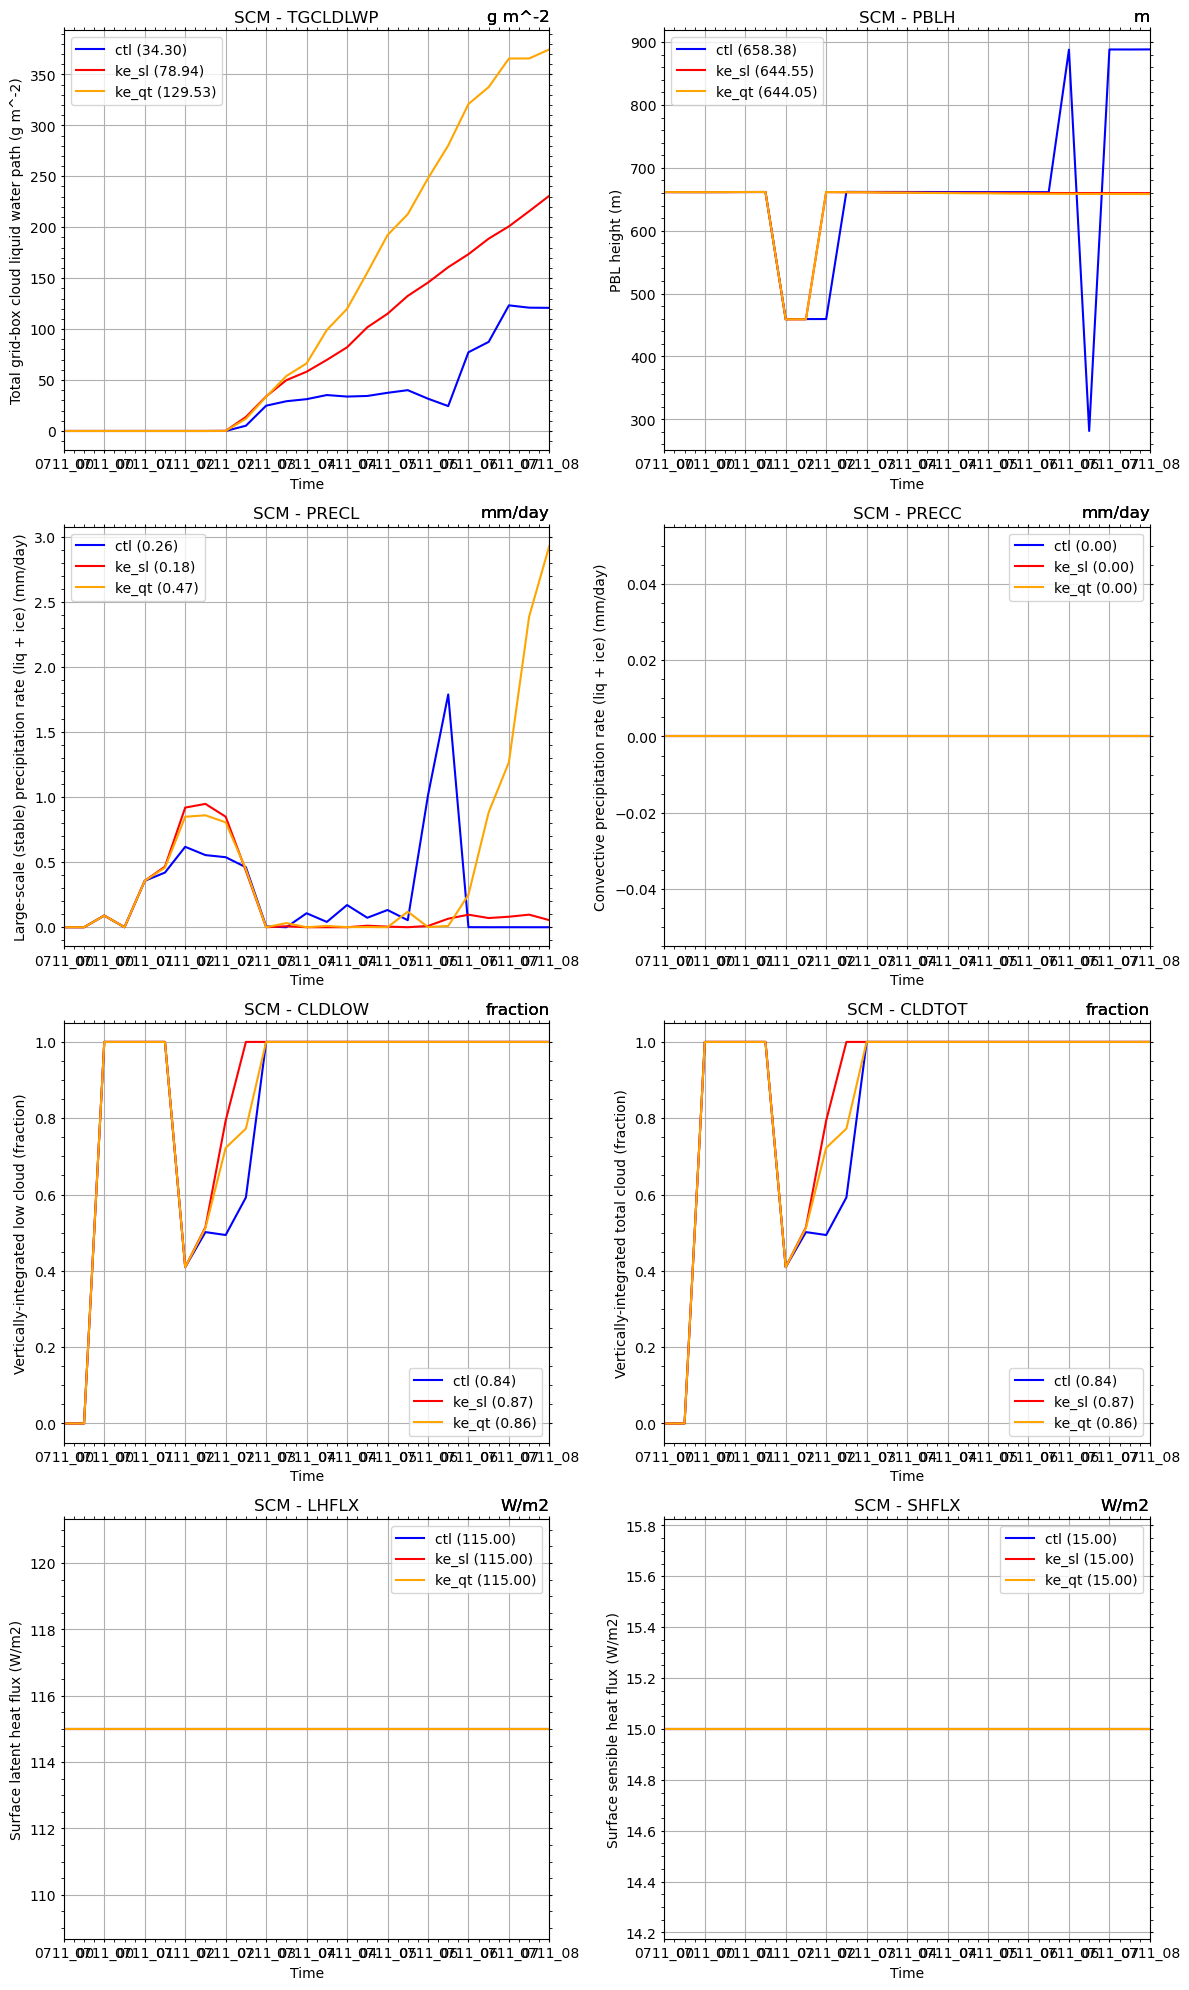

In [277]:
#var_lists = ["TGCLDLWP", "TMQ", "SOLIN", "FLDS", "PBLH", "PBLH", "LHFLX", "SHFLX", "PRECL", "PRECC", "CLDLOW", "CLDTOT"]
var_lists = ["TGCLDLWP", "PBLH", 
             "PRECL", "PRECC", 
             "CLDLOW", "CLDTOT", 
             "LHFLX", "SHFLX",
            ]

#var_lists = ["TGCLDLWP", "PBLH", "PRECL", "CLDLOW"]

#var_lists = ["PBLH", "TGCLDLWP", "UW_tpert", "UW_qpert", "UW_wpert", "UW_tkes"]

titles = [f"SCM - {var}" for var in var_lists]

#colors=None ; linestyles=None; markers=None

plot_xy_series_1vNf_panel_Nv(ds_list, var_lists, labels, 
                             colors=colors, linestyles=linestyles, markers=markers, titles=titles,
                             time_interval=2,
                            )

## plot SCM - cn_time_lev

In [ ]:
ds_list = [ds_scm_dict[key] for key in labels if key in ds_scm_dict]
yy_list = ds_list.copy()

#var_names_qltend = ['QLTEND_TOT', 'DQLCORE', 'PTECLDLIQ', 'MACPDLIQ','VDCLDLIQ', 'MPDLIQ', 'CMFDLIQ','SHDLFLIQ', ]
#var_names_qltend = ['QLTEND_TOT', 'DQLCORE', 'PTECLDLIQ', 'MACPDLIQ', 'MPDLIQ', 'VDCLDLIQ']
#var_names_qltend = ['MACPDLIQ', 'MPDLIQ', 'VDCLDLIQ', 'QLTEND_TOT', 'DQLCORE', 'PTECLDLIQ', ]
#var_names = ["CLDLIQ","CLOUD", "ICWMR", "RELHUM"] + var_names_qltend
var_names = [
    "CLDLIQ", "UW_qrl", "DTV", "VD01", "VDCLDLIQ",
    "UW_ri",
    "UW_tke", "UW_bprod", "UW_sprod", "UW_kvh", "UW_kvm", 
    "UW_wet", "UW_web", "UW_jtbu", "UW_jbbu",
    "UW_ebrk", 
    "UW_evhc", "UW_jt2slv", 
            ]

var_names = ['QLTEND_TOT', 'DQLCORE', 'PTECLDLIQ', 'ZMDLIQ', 'CMFDLIQ', 'DPDLFLIQ', 'SHDLFLIQ', 'MACPDLIQ', 'MPDLIQ', 'VDCLDLIQ']

titles = labels.copy()

state_names = None #["state"] + ["Qtend"]*len(var_names_qltend)

user_settings = {
    "CLDLIQ": {"cmap": "GnBu", "levels": np.arange(0, 0.4, 0.05)},
    "QLTEND_TOT": {"cmap":"PuOr", "levels": np.arange(-8, 8, 1),  "norm_option":"boundary"},
}
# Assign the same settings to DQLCORE and PTECLDLIQ
for var in var_names_qltend:
    user_settings[var] = user_settings["QLTEND_TOT"].copy()

plot_cn_time_lev_1v1f_panel_CfRv(ds_list, yy_list, titles, var_names, state_names, user_settings=user_settings, 
                        time_tick_major_interval=1)

## plot SCM - profiles (1v, 1t, Nf), panel (col: var/time, row: time/var)

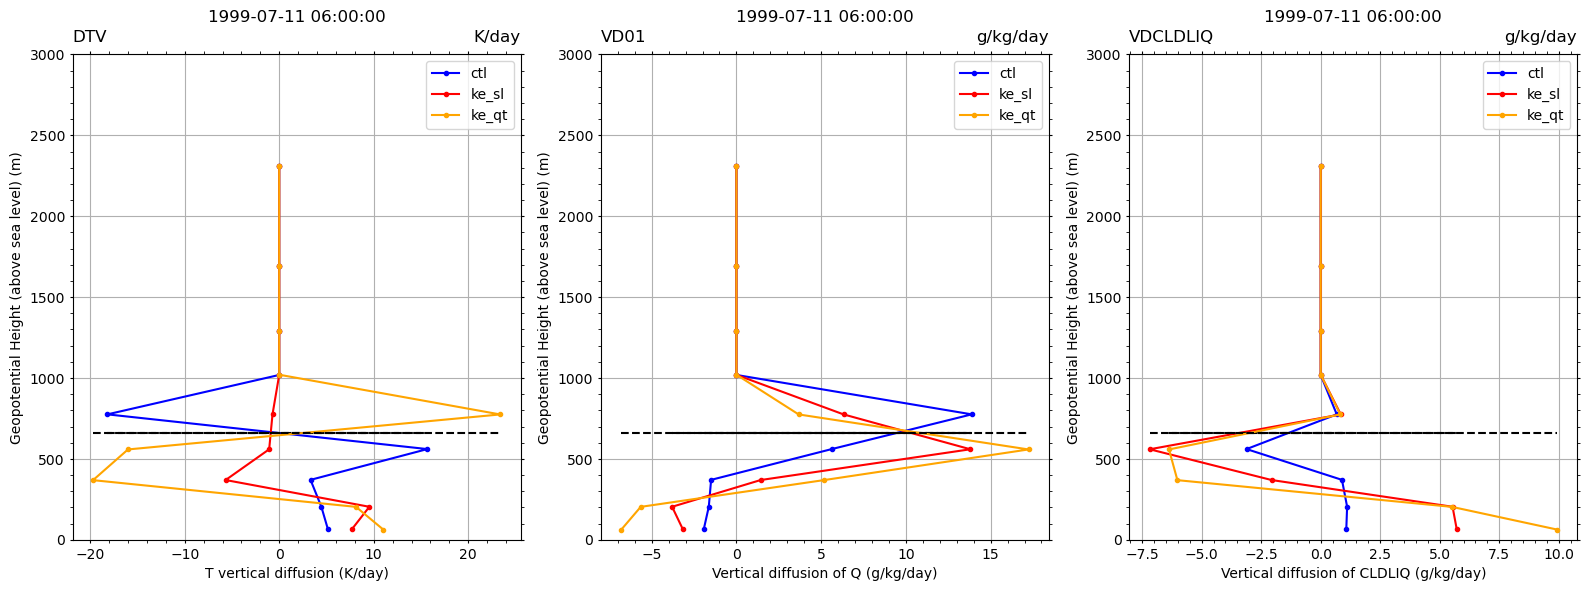

In [282]:
ds_list = [ds_scm_dict[key] for key in labels if key in ds_scm_dict]
yy_list = ds_list.copy()

opt_dict = None
opt_dict = {
    "labels": labels,
    "colors": colors,
}

var_names_qltend = ['QLTEND_TOT', 'DQLCORE', 'PTECLDLIQ', 'ZMDLIQ', 'CMFDLIQ', 'DPDLFLIQ', 'SHDLFLIQ', 'MACPDLIQ', 'MPDLIQ', 'VDCLDLIQ']
#var_names_qltend = ['QLTEND_TOT', 'DQLCORE', 'PTECLDLIQ', 'MACPDLIQ', 'MPDLIQ', 'VDCLDLIQ']
#var_names_qltend = ['MACPDLIQ', 'MPDLIQ', 'VDCLDLIQ', 'QLTEND_TOT', 'DQLCORE', 'PTECLDLIQ', ]

var_names = ["CLDLIQ","UW_ql", "UW_qrl", "UW_tke",
             "UW_kvh","T","DTV",
             "UW_kvh","Q","VD01",
            ]

#var_names = ["sl_pre_PBL","sl_pre_PBL_off", "sl_aft_PBL_off", "slten_PBL_off", "UW_kvh", "ql_pre_PBL"]
#var_names = ["UW_kvh", "ql_pre_PBL", "slten_PBL_off", "qtten_PBL_off"]
#var_names = ["ql_pre_PBL","tten_PBL_off", "qvten_PBL_off","qlten_PBL_off"]
#var_names = ["ql_pre_PBL","KVH_off","tten_PBL_off", "qvten_PBL_off","qlten_PBL_off"]

#var_names = ["qt_pre_PBL","qt_pre_PBL_off", "qt_aft_PBL_off", "qtten_PBL_off", "UW_kvh", "CLDLIQ"]
#var_names = ["t_pre_PBL","t_pre_PBL_off", "t_aft_PBL_off", "tten_PBL_off", "UW_kvh", "CLDLIQ"]
#var_names = ["qv_pre_PBL","qv_pre_PBL_off", "qv_aft_PBL_off", "qvten_PBL_off", "UW_kvh", "CLDLIQ"]


#var_names = ["Q","UW_tke", "UW_kvh","VD01"]
#var_names = ["sl_pre_PBL","UW_tke", "UW_kvh","slten_PBL"]
#var_names = ["UW_tke", "UW_kvh","slten_PBL"]
#var_names = ["CLDLIQ","UW_tke", "UW_kvh","UW_wet"]
var_names = ["DTV","VD01","VDCLDLIQ"]

#var_names = ["THETA_L","Q","RELHUM","CLDLIQ","CLOUD"] #, "ICWMR"] #+ var_names_qltend
#var_names = ['MACPDLIQ', 'MPDLIQ', 'VDCLDLIQ']
#var_names = ["UW_tke", "UW_kvh", "DTV", "VD01"]

xmin_xmax = None
#xmin_xmax = [(280,295), (0,10), (0,100)]
ymin_ymax = [(0,3000)]*len(var_names)*2

#time_idxes = np.arange(0,7)
#time_idxes = np.arange(10,18)
#time_idxes = np.arange(21,24)

#time_idxes = None
#time_idxes = [0,1,5,6]
time_idxes = [18]

panel_opt = "CvRt"
#panel_opt = "CtRv"
plot_xy_profile_1v1tNf_panel(ds_list, yy_list, var_names, opt_dict,
                             lev_select=lev_select,  time_idxes=time_idxes,
                              xmin_xmax=xmin_xmax, ymin_ymax=ymin_ymax, panel_opt=panel_opt,
                              axes=None)
    

## plot SCM - profile (Nv, 1t, 1f), panel (col:files, row: vars)

/tmp/ipykernel_3209321/2795935950.py:93: UserWarning: func [plot_xy_profile_Nv1t1f]: Variable 'ql_off_aft_PBL' not found in the dataset.
  warnings.warn(f"func [{func_name}]: Variable '{var_name}' not found in the dataset.", UserWarning)
/tmp/ipykernel_3209321/2795935950.py:93: UserWarning: func [plot_xy_profile_Nv1t1f]: Variable 'ql_off_aft_PBL' not found in the dataset.
  warnings.warn(f"func [{func_name}]: Variable '{var_name}' not found in the dataset.", UserWarning)


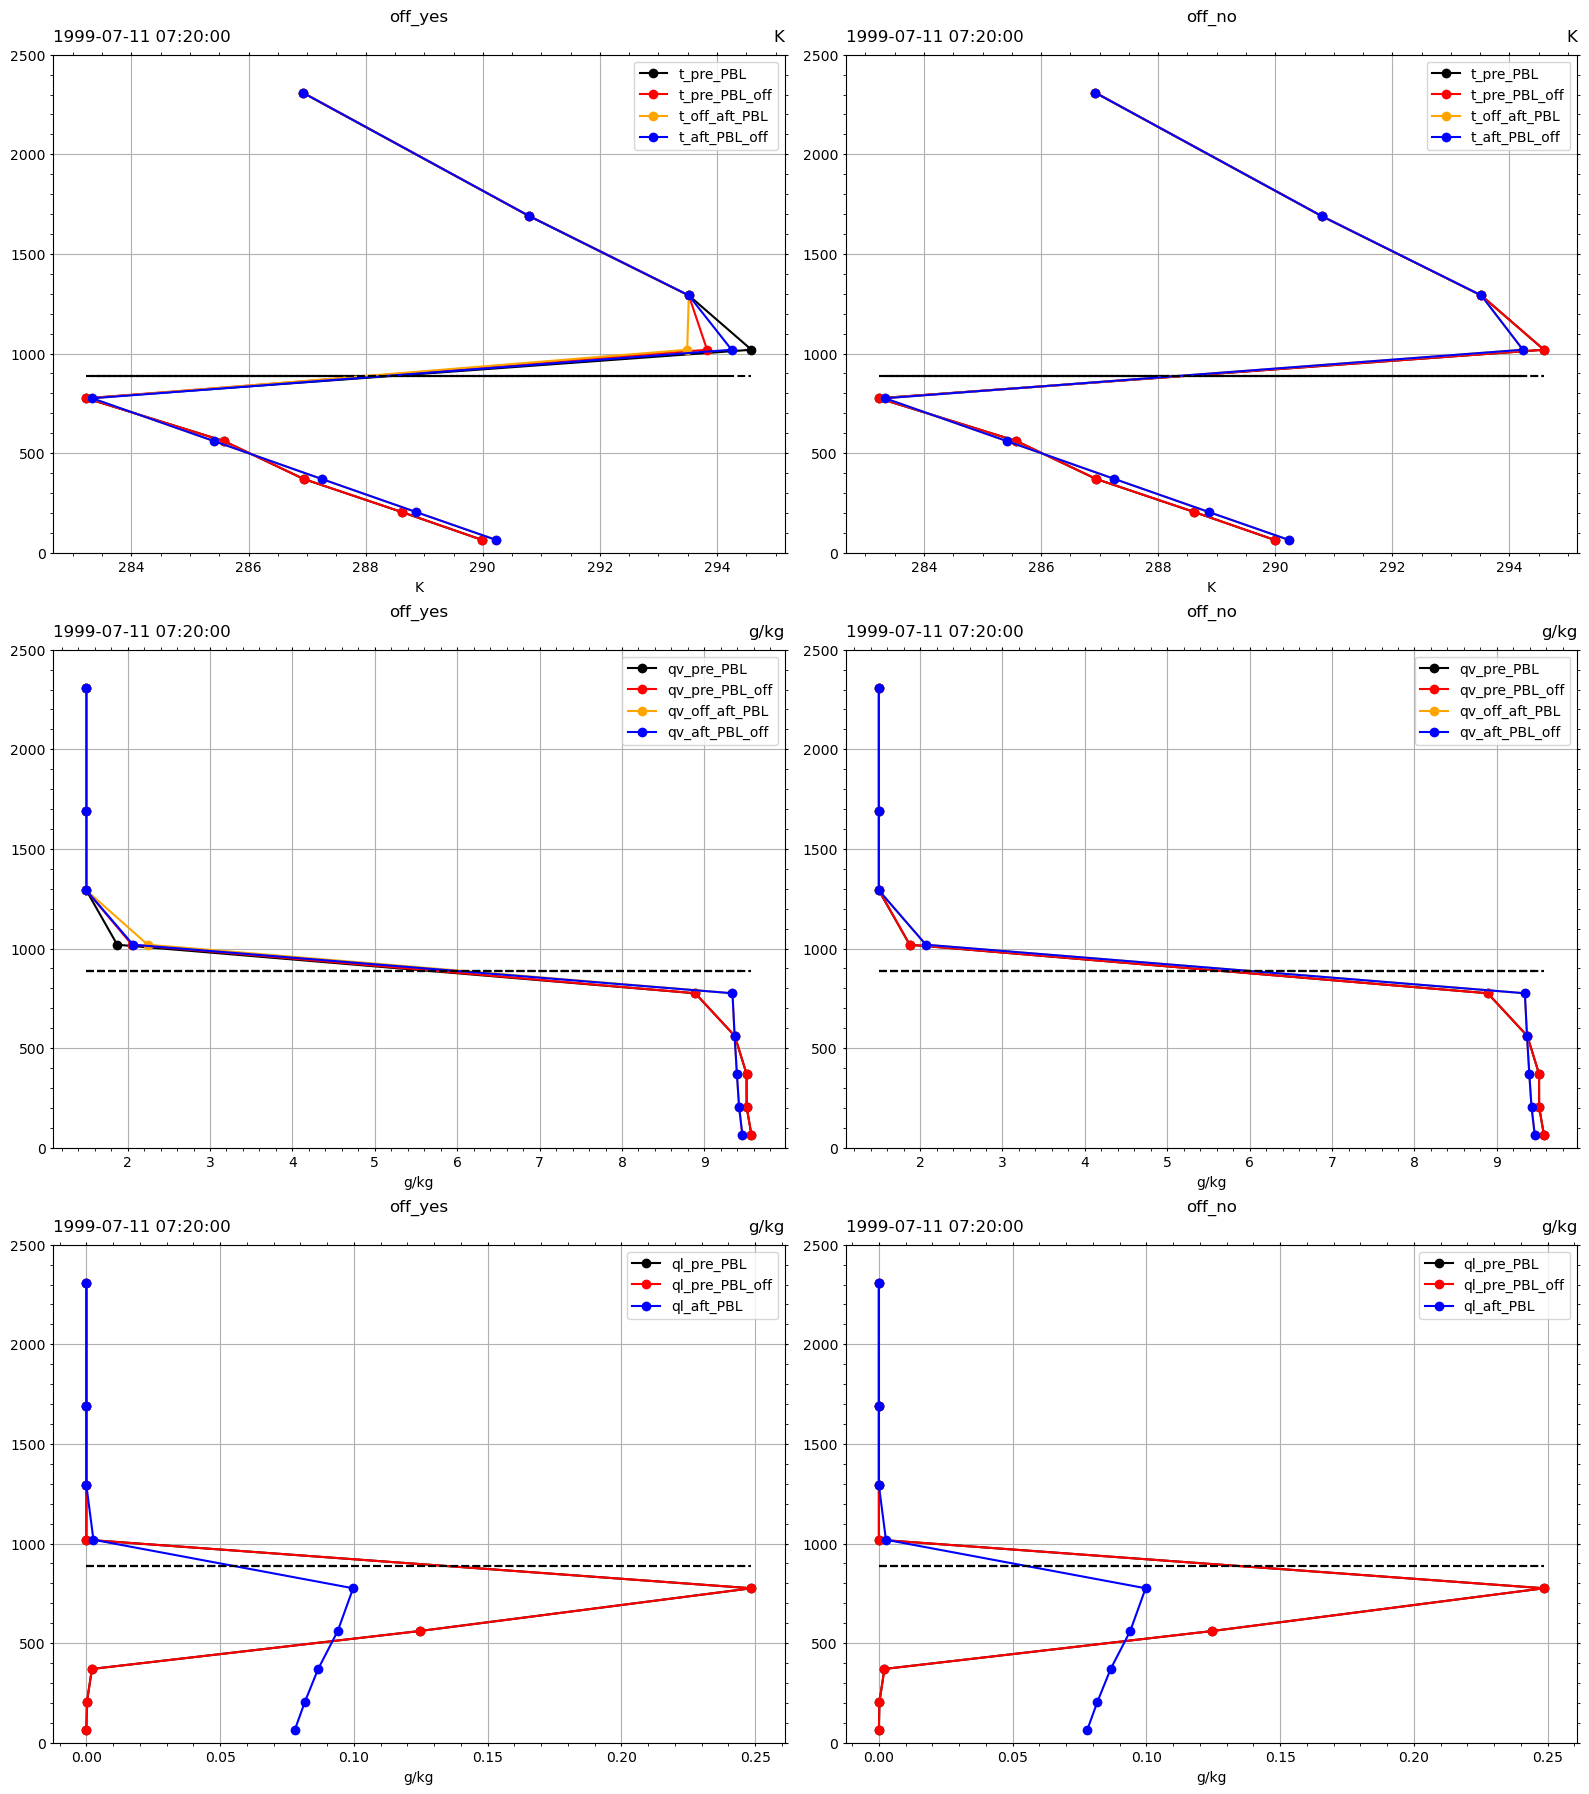

In [253]:
#labels = ["rf01_tpdf_dt1200", "rf01_tpdf_dt300", "rf01_tpdf_dt60",]
#ds_list = [ds_scm_dict[key] for key in labels if key in ds_scm_dict]
#yy_list = ds_list.copy()

rainbow_colors = [
    'red',
    'orange',
    'gold',         # like yellow
    'limegreen',    # like green
    'deepskyblue',  # like cyan/blue
    'blue',
    'indigo',
    'violet',
    'magenta'
]

#state_names = ["state", "Qtend", "Qtend"]  # Ensure state_names corresponds to each var_name
var_list_custom = {
    "test1": {
        "vars": ['TTEND_TOT', 'DTCORE', 'PTTEND'],
        "labels": None,
        "colors": ['r','g','y'],
        "linestyles": None,
        "markers": None,
    },
    "test2": {
        #"vars": ['QRL', 'QRS', 'DTV'],
        "vars": ["QRL"],
        "linestyles": ['-'],
        "labels": ["QRL yaya"],
    },    
    "qt_pbl":{
    "vars": ["qt_pre_PBL","qt_pre_PBL_off", "qt_off_aft_PBL", "qt_aft_PBL_off"],
    "markers": ['o']*5,
    "colors": ["k","r","orange","b"],
    },
    "t_pbl":{
    "vars": ["t_pre_PBL","t_pre_PBL_off", "t_off_aft_PBL", "t_aft_PBL_off"],
    "markers": ['o']*5,
    "colors": ["k","r","orange","b"],
    },
    "qv_pbl":{
    "vars": ["qv_pre_PBL","qv_pre_PBL_off", "qv_off_aft_PBL", "qv_aft_PBL_off"],
    "markers": ['o']*5,
    "colors": ["k","r","orange","b"],
    },   
    "ql_pbl":{
    "vars": ["ql_pre_PBL","ql_pre_PBL_off", "ql_off_aft_PBL", "ql_aft_PBL"],
    "markers": ['o']*5,
    "colors": ["k","r","orange","b"],
    },   
    "u_pbl":{
    "vars": ["u_pre_PBL","u_pre_PBL_off", "u_aft_PBL"],
    "markers": ['o']*5,
    "colors": ["k","r","b","m"],
    },   
    "sl_pbl":{
    "vars": ["sl_pre_PBL","sl_pre_PBL_off", "sl_off_aft_PBL", "sl_aft_PBL_off"],
    "markers": ['o']*5,
    "colors": ["k","r","orange","b"],
    }    
}

#var_names = ["DT_budget", "DQ_budget", "DQL_budget"]
#var_names = ["CLDLIQ","UW_tke","UW_kv","T","DTV","Q","VD01"]
var_names = ["CLDLIQ","UW_tke","UW_kv",
             "T_pbl","DTV",
             "q_pbl","VD01",
             "ql_pbl","VDCLDLIQ","UW_kv",
             "sl_pbl","T_pbl","UW_kv",
             "DT_budget",
            ]
var_names = ["s_phys", "DT_budget",
             #"t_phys", "DT_budget",
             "q_phys","DQ_budget",
             "ql_phys", "DQL_budget",
             "UW_kv", "UW_tke", "CLDLIQ",
             "UW_wet", "UW_turbtype",
            ]

#var_names = ["DT_budget", "DQ_budget", "DQL_budget"]
#var_names = ["sl_pbl", "qt_pbl", "t_pbl", 'qv_pbl', "ql_pbl"]

state_names = None #["state"] + ["Qtend"]*(len(var_names)-1)
titles = labels.copy()

xmin_xmax = None
#xmin_xmax = [(-15,15), (-15,15),(-6,6)]


#time_idxes = [0,1,2,3]
#time_idxes = [1,2,3,4]

#opt_panel = "1fCtRv"
#time_idxes = list(range(0,4))

opt_panel = "1tCfRv"
time_idxes = [22]
#var_names = ["DQL_budget"]

#var_names = ["qt_pbl","sl_pbl","qv_pbl","t_pbl","u_pbl","ql_pre_PBL"]
#var_names = ["sl_pbl", "qt_pbl"]
var_names = ["t_pbl", 'qv_pbl', "ql_pbl"]


ymin_ymax=[(0,2500)]*len(var_names)
plot_xy_profile_Nv1t1f_panel_Rv_CfCt(ds_list, yy_list, titles, var_names, state_names, 
                             xmin_xmax=xmin_xmax, ymin_ymax=ymin_ymax, time_idxes=time_idxes,
                             var_list_custom=var_list_custom, 
                             opt_panel=opt_panel
                                    )



In [ ]:
time_idxes = list(range(4,7))

opt_panel = "1fCtRv"
#opt_panel = "1tCfRv"
plot_xy_profile_Nv1t1f_panel_Rv_CfCt(ds_list, yy_list, titles, var_names, state_names, 
                             xmin_xmax=xmin_xmax, time_idxes=time_idxes,
                             var_list_custom=var_list_custom, 
                             opt_panel=opt_panel
                                    )

## plot SCM - profile (1v, Nt, 1f), panel (col: files, row: vars)

In [ ]:
#labels = ["rf01_tpdf_dt1200", "rf01_tpdf_dt300", "rf01_tpdf_dt60",]
#ds_list = [ds_scm_dict[key] for key in labels if key in ds_scm_dict]
#yy_list = ds_list.copy()
titles = labels.copy()

state_names = None
#var_names = ["T", "Q","CLDLIQ", "ICWMR", "MACPDLIQ", "MPDLIQ", "SHDLFLIQ", "VDCLDLIQ"]
#var_names = ["T", "Q", "CLDLIQ", "ICWMR", "NUMLIQ", "RELHUM", "THETA_L"]
var_names = ["T", "Q", "UW_kvh"]

xmin_xmax = None
#xmin_xmax = [(282,296), (1,10), (0, 0.5)]

lg_labels=None ; colors=None ; linestyles=None; markers=None
#colors = ['b','r','k'] ; markers = ["^"]*3 ; linestyles = ['--']*5 ; lg_labels = ['t1','t2']
    
plot_xy_profiles_1vNt1f_panel_CfRv(ds_list, yy_list, titles, var_names, state_names, xmin_xmax=xmin_xmax,
                                  labels=lg_labels, colors=colors, linestyles=linestyles, markers=markers,  
                                  )

# Plot - hindcast experiments (Nf)

## read data

In [ ]:
## Only support icdate=0704~0711 in  ~/data/data.TaiESM1_hindcast/data.TaiESM1.July2001_hindcast02/run, 

icdate = "20010707" ; ss5="00000"
#icdate = "20010711" ; ss5="43200"

#region = "DYCOMS" ; lat=None ; lon=None
region = "lat_lon" ; lat=31.5 ; lon=240

lev_select = "Z3"   ; lev_max = 2000 ; lev_min = 0
#lev_select = "play" ; lev_max = None ; lev_min = None

# select all time and lev
icdata_option = "qq02_macrop_park"
ds_dict_park, yy_dict_park = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
                                                                  lev_select=lev_select, lev_min=lev_min, lev_max=lev_max)

icdata_option = "qq02_macrop_tpdf"
ds_dict_tpdf, yy_dict_tpdf = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
                                                                  lev_select=lev_select, lev_min=lev_min, lev_max=lev_max)

icdata_option = "qq02_macrop_updf"
ds_dict_updf, yy_dict_updf = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
                                                                  lev_select=lev_select, lev_min=lev_min, lev_max=lev_max)

icdata_option = "qq02_macrop_tpdf_turb_a2l_50"
ds_dict_a2l_50, yy_dict_a2l_50 = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
                                                                  lev_select=lev_select, lev_min=lev_min, lev_max=lev_max)

icdata_option = "qq02_macrop_tpdf_turb_a2l_10"
ds_dict_a2l_10, yy_dict_a2l_10 = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
                                                                  lev_select=lev_select, lev_min=lev_min, lev_max=lev_max)

icdata_option = "qq02_macrop_tpdf_rhcrit_95"
ds_dict_rhcrit_95, yy_dict_rhcrit_95 = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
                                                                  lev_select=lev_select, lev_min=lev_min, lev_max=lev_max)

icdata_option = "qq02_macrop_tpdf_rhcrit_70"
ds_dict_rhcrit_70, yy_dict_rhcrit_70 = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
                                                                  lev_select=lev_select, lev_min=lev_min, lev_max=lev_max)

icdata_option = "qq02_macrop_tpdf_rhcrit_99"
ds_dict_rhcrit_99, yy_dict_rhcrit_99 = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
                                                                  lev_select=lev_select, lev_min=lev_min, lev_max=lev_max)

In [ ]:
region = "DYCOMS" ; lat=None ; lon=None
#region = "lat_lon" ; lat=31.5 ; lon=240

lev_select = "Z3"   ; lev_max = 2000 ; lev_min = 0
#lev_select = "play" ; lev_max = None ; lev_min = None

icdate = "20010707" ; ss5="00000"

icdata_option = "qq02_macrop_tpdf"

#--- RF01
start_str = "20010710_060000"
end_str = "20010710_150000"
ds_dict_tpdf_rf01_0707, yy_dict_tpdf_rf01_0707 = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
                                                                  lev_select=lev_select, lev_min=lev_min, lev_max=lev_max,
                                                                  start_str=start_str, end_str=end_str)

#--- RF02
start_str = "20010711_060000"
end_str = "20010711_150000"
ds_dict_tpdf_rf02_0707, yy_dict_tpdf_rf02_0707 = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
                                                                  lev_select=lev_select, lev_min=lev_min, lev_max=lev_max,
                                                                  start_str=start_str, end_str=end_str)

#--- selected time range
#start_str = "20010708_180000"
#end_str = "20010709_000000"

start_str = "20010709_210000"
end_str = "20010710_030000"

#start_str = "20010711_060000"
#end_str = "20010711_120000"
ds_dict_tpdf_rf01_time0, yy_dict_tpdf_rf01_time0 = get_ds_time_level_2d_vars_for_xy_plot(icdate, icdata_option=icdata_option, ss5=ss5, region=region, lat=lat, lon=lon,
                                                                  lev_select=lev_select, lev_min=lev_min, lev_max=lev_max,
                                                                  start_str=start_str, end_str=end_str)




## determine subset

In [ ]:
#subset = "rhcrit"
#subset = "rf01"
#subset = "time0"
subset = "tpdf"
#subset = "tpdf_updf"
#subset = "tpdf"
#subset = "a2l"

#print(subset)

if (subset == "a2l"):
    ds_list = [ds_dict_a2l_10, ds_dict_tpdf, ds_dict_a2l_50, ds_dict_updf]
    yy_list = [yy_dict_a2l_10, yy_dict_tpdf, yy_dict_a2l_50, yy_dict_updf]
    titles = ["a2l_10", "tpdf", "a2l_50", "updf"]
    colors = ["orange", "r", "b", "green", "m"]
    labels = titles.copy()

elif (subset == "tpdf"):
    ds_list = [ds_dict_tpdf]
    yy_list = [yy_dict_tpdf]
    titles = ["tpdf"]
    colors = ["red"]
    labels = titles.copy()

elif (subset == "tpdf"):
    ds_list = [ds_dict_tpdf]
    yy_list = [yy_dict_tpdf]
    titles = ["tpdf"]
    colors = ["red"]
    labels = titles.copy()

elif (subset == "tpdf_updf"):
    ds_list = [ds_dict_tpdf, ds_dict_updf]
    yy_list = [yy_dict_tpdf, yy_dict_updf]
    titles = ["tpdf", "updf"]
    colors = ["red", "blue"]
    labels = titles.copy()

elif (subset == "rhcrit"):
    print(subset)
    ds_list = [ds_dict_rhcrit_70, ds_dict_tpdf, ds_dict_rhcrit_95, ds_dict_rhcrit_99, ds_dict_park]
    yy_list = [yy_dict_rhcrit_70, yy_dict_tpdf, yy_dict_rhcrit_95, yy_dict_rhcrit_99, yy_dict_park]
    titles = ["RHcrit_70", "tpdf", "RHcrit_95", "RHcrit_99", "park"]
    colors = ["orange", "r", "green", "b", "gray"]
    labels = titles.copy()
    
elif (subset == "rf01"):
    print(subset)
    ds_list = [ds_dict_tpdf_rf01_0707]
    yy_list = [yy_dict_tpdf_rf01_0707]
    titles = ["rf01_tpdf_hindcast_0707"]
    colors = ["orange"] #, "r", "green", "b", "gray"]
    labels = titles.copy()

elif (subset == "rf02"):
    print(subset)
    ds_list = [ds_dict_tpdf_rf02_0707]
    yy_list = [yy_dict_tpdf_rf02_0707]
    titles = ["rf02_tpdf_hindcast_0707"]
    colors = ["red"] #, "r", "green", "b", "gray"]
    labels = titles.copy()

elif (subset == "time0"):
    print(subset)
    ds_list = [ds_dict_tpdf_rf01_time0]
    yy_list = [yy_dict_tpdf_rf01_time0]
    titles = ["rf01_tpdf_hindcast_time0"]
    colors = ["blue"] #, "r", "green", "b", "gray"]
    labels = titles.copy()

#print(len(labels))
#print(len(ds_list))


## print out

In [ ]:
#ds_list[0]['state']

In [ ]:
tt_idx_tmp=1
print(ds_list[0]['state']['time'].isel(time=tt_idx_tmp))

Z3_tmp = yy_list[0]['Z3'].isel(time=tt_idx_tmp).values
Z3_ilev_tmp = yy_list[0]['Z3_ilev'].isel(time=tt_idx_tmp).values
KVH_tmp = ds_list[0]['state']['KVH'].isel(time=tt_idx_tmp).values
CLDLIQ_tmp = ds_list[0]['state']['CLDLIQ'].isel(time=tt_idx_tmp).values * 1e3  # change units from kg/kg to g/kg
T_tmp = ds_list[0]['state']['T'].isel(time=tt_idx_tmp).values 

DTV_tmp = ds_list[0]['Ttend']['DTV'].isel(time=tt_idx_tmp).values * 86400. # change units from K/S to K/day

print("")
print("k, Z3")
for k in range(len(Z3_tmp)):
    print(k+0.5, Z3_ilev_tmp[k], "KVH=", KVH_tmp[k])
    print(k+1, "  ",Z3_tmp[k], "DTV=", DTV_tmp[k], "CLDLIQ=", CLDLIQ_tmp[k], "T=", T_tmp[k])

# Print with header
#print("Z3, KVH")
#print(combined)
#Z3_tmp

## plot - time series

In [ ]:
subset = "test111"

if (subset == "test000"):
    ds_list = [ds_dict_a2l_10, ds_dict_tpdf, ds_dict_a2l_50, ds_dict_updf, ds_dict_park]
    colors = ["orange", "r", "b", "green", "m"]
    labels = ["a2l_10", "tpdf", "a2l_50", "updf", "park"]

#var_lists = ["TGCLDLWP", "TGCLDIWP", "FSDS", "PBLH", "LHFLX", "SHFLX", "PRECL", "PRECC", "CLDLOW", "CLDMED", "CLDHGH"]
var_lists = ["TGCLDLWP", "CLDLOW", "LHFLX", "SHFLX", "PRECL", "PRECC","PBLH","SOLIN"]
#var_lists = ["FSDS", "PBLH"]

titles_series = [f"DYCOMS domain-avg - {var}" for var in var_lists]
#plot_xy_series_NvNf_panel(ds_list, var_lists, colors, labels, titles_series)

linestyles=None; markers=['o']*30
plot_xy_series_1vNf_panel_Nv(ds_list, var_lists, labels, 
                             sub_list_name = "1d_time",
                             colors=colors, linestyles=linestyles, markers=markers, titles=titles_series,
                             time_interval=24,
                            )

## plot - cn time_lev

In [ ]:
subset = "test000"
if (subset == "test111"):
    ds_list = [ds_dict_a2l_10, ds_dict_tpdf, ds_dict_a2l_50, ds_dict_updf]
    yy_list = [yy_dict_a2l_10, yy_dict_tpdf, yy_dict_a2l_50, yy_dict_updf]
    titles = ["a2l_10", "tpdf", "a2l_50", "updf"]

#var_names_qltend = ['QLTEND_TOT', 'DQLCORE', 'PTECLDLIQ', 'ZMDLIQ', 'CMFDLIQ', 'DPDLFLIQ', 'SHDLFLIQ', 'MACPDLIQ', 'MPDLIQ', 'VDCLDLIQ']
#var_names_qltend = ['QLTEND_TOT', 'DQLCORE', 'PTECLDLIQ', 'MACPDLIQ', 'MPDLIQ', 'VDCLDLIQ']
var_names_qltend = ['MPDLIQ', 'MACPDLIQ', 'VDCLDLIQ', 'QLTEND_TOT', 'DQLCORE', 'PTECLDLIQ', ]

var_names = ["CLDLIQ", "CLOUD", "ICWMR"] + var_names_qltend
state_names = ["state"]*3 + ["Qtend"]*len(var_names_qltend)

#var_names = ['MPDLIQ', 'MACPDLIQ', 'VDCLDLIQ']
#state_names = ["Qtend"]*3

#var_names = ["CLDLIQ", "CLOUD"]
#state_names = ["state"]*2

user_settings = {
    "CLDLIQ": {"cmap": "GnBu", "levels": np.arange(0, 0.2, 0.01)},
    "QLTEND_TOT": {"cmap":"PuOr", "levels": np.arange(-5, 6, 1),  "norm_option":"boundary"},
    "CLOUD": {"levels": np.arange(0, 1, 0.1)},
}
# Assign the same settings to DQLCORE and PTECLDLIQ
for var in var_names_qltend:
    user_settings[var] = user_settings["QLTEND_TOT"].copy()

plot_cn_time_lev_1v1f_panel_CfRv(ds_list, yy_list, titles, var_names, state_names, user_settings=user_settings,
                                time_tick_major_interval=1,
                                )

In [ ]:
subset = "test000"
if (subset == "test111"):
    ds_list = [ds_dict_a2l_10, ds_dict_tpdf, ds_dict_a2l_50, ds_dict_updf]
    yy_list = [yy_dict_a2l_10, yy_dict_tpdf, yy_dict_a2l_50, yy_dict_updf]
    titles = ["a2l_10", "tpdf", "a2l_50", "updf"]

#var_names_qvtend = ['QVTEND_TOT', 'DQVCORE', 'PTEQ', 'ZMDQ', 'EVAPQZM', 'CMFDQ', 'MACPDQ', 'MPDQ', 'VD01']
var_names_qvtend = ['QVTEND_TOT', 'DQVCORE', 'PTEQ', 'MACPDQ', 'MPDQ', 'VD01']

var_names = ["Q"] + var_names_qvtend

state_names = ["state"] + ["Qtend"]*len(var_names_qvtend)

user_settings = {
    "Q": {"cmap": "GnBu", "levels": np.arange(1, 12, 1)},
    "QVTEND_TOT": {"cmap":"PuOr", "levels": np.arange(-8, 8, 1),  "norm_option":"boundary"},
}
# Assign the same settings to DQLCORE and PTECLDLIQ
for var in var_names_qltend:
    user_settings[var] = user_settings["QVTEND_TOT"].copy()

plot_cn_time_lev_1v1f_panel_CfRv(ds_list, yy_list, titles, var_names, state_names, user_settings=user_settings,
                                 time_tick_major_interval=1,
                                 )

## plot - profile (Nv, Nt, 1f), panel (col: files)

In [ ]:
state_name = "Qtend"
var_names = ["QLTEND_TOT","DQLCORE","PTECLDLIQ","MACPDLIQ","VDCLDLIQ"]
opt_xy = {
    "colors":["blue","yellow","red","lime","purple"],
    "linestyles": ["-"] * len(var_names),
    "xlabel": "cloud liquid tendency", 
    #"labels":["a","b","c","d","e"],
}
xmin_xmax = (-8, 8)

plot_xy_profile_NvNt1f_panel_Cf(ds_list, yy_list, labels, var_names, state_name=state_name, xmin_xmax=xmin_xmax, opt_xy=opt_xy)

## plot - profile (1v, Nt, 1f), panel (col: files, row: vars)

### T, Q, CLDLIQ

In [ ]:
var_names = ["T", "Q","CLDLIQ", "RELHUM", "KVH"]
state_names = ["state"] * len(var_names)
xmin_xmax = None
ymin_ymax = (0,2000)
#xmin_xmax = [(282,298), (1,10), (0, 0.25), (0, 100)]
plot_xy_profiles_1vNt1f_panel_CfRv(ds_list, yy_list, titles, var_names, state_names, xmin_xmax=xmin_xmax, ymin_ymax=ymin_ymax)

## plot - profile (1v, Nt, 1f), panel (col: vars, row: files)

In [ ]:
#state_names = ["state","state","Ttend", "state", "Ttend" ] #, "Ttend", ]  # Ensure state_names corresponds to each var_name
#var_names = ["T", "KVH", "DTV", "CLDLIQ", "QRL"]

state_names = ["state","state","state","Ttend", "state", "state"] #, "Ttend", ]  # Ensure state_names corresponds to each var_name
var_names = ["THETA_diag", "THETA_L", "KVH", "DTV", "CLDLIQ", "RELHUM"]


xmin_xmax = None
#xmin_xmax = [(0,250),(0,250),]
ymin_ymax = (0,2000)

plot_xy_profiles_1vNt1f_panel_CvRf(ds_list, yy_list, titles, var_names, state_names, xmin_xmax=xmin_xmax, lev_select="Z3", ymin_ymax=ymin_ymax)

## plot - profile (Nv, 1t, 1f), 
### panel 1fCtRv: (Nt, 1f; col:times, row: vars)
### panel 1tCfRv: (1t, Nf; col:files, row: vars)

In [ ]:
subset = "test111"
if (subset == "test000"):
    nn=1
    ds_list = [ds_dict_tpdf_rf01_0707] * nn
    yy_list = [yy_dict_tpdf_rf01_0707] * nn
    titles = ["tpdf_0707"] * nn
    colors = ["orange"] * nn #, "r", "green", "b", "gray"]
    labels = titles.copy()

state_names = ["Ttend","Qtend","Qtend"]  # Ensure state_names corresponds to each var_name
var_names = ["DT_budget","DQ_budget","DQL_budget"]
xmin_xmax = None
xmin_xmax = [(-15,15), (-15,15),(-6,6)]

#xmin_xmax = [(280, 290), (-15,15)]

#time_idx=None
#time_idxes=[0,2,5]
#plot_xy_profile_Nv1t1f_panel_CtRv(ds_list, yy_list, titles, var_names, state_names, xmin_xmax=xmin_xmax, time_idxes=time_idxes)

opt_panel = "1fCtRv"
#opt_panel = "1tCfRv"  

#time_idxes = list)_ = [1,2,3] range(0,3)
time_idxes = list(range(0,3))
plot_xy_profile_Nv1t1f_panel_Rv_CfCt(ds_list, yy_list, titles, var_names, state_names, xmin_xmax=xmin_xmax, time_idxes=time_idxes,
                                     opt_panel=opt_panel,
                                     )